#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [508]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [507]:
hdr = db[{{ uid }}]

TypeError: unhashable type: 'set'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [4]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [ ]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

In [509]:
%run develop.py
%run two_time.py

In [8]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [9]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [10]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    uid = 'ffe9d518'  # 10 mTorr 1sec/frame
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [14]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


### Get data path

In [12]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/8/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [15]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [16]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## load a mask
#### load the mask saved in the mask_pipeline

In [17]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [18]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


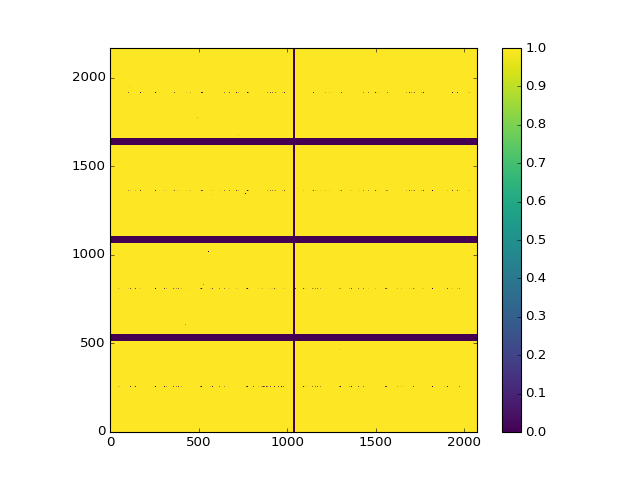

In [510]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [20]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [21]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [22]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [23]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

In [24]:
bad_frames = np.where( kymo_sum > 1e5)[0]
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

<IPython.core.display.Javascript object>


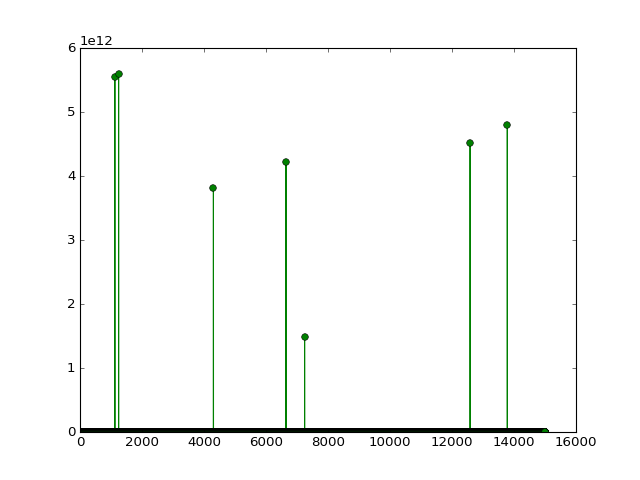

In [25]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [26]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [27]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


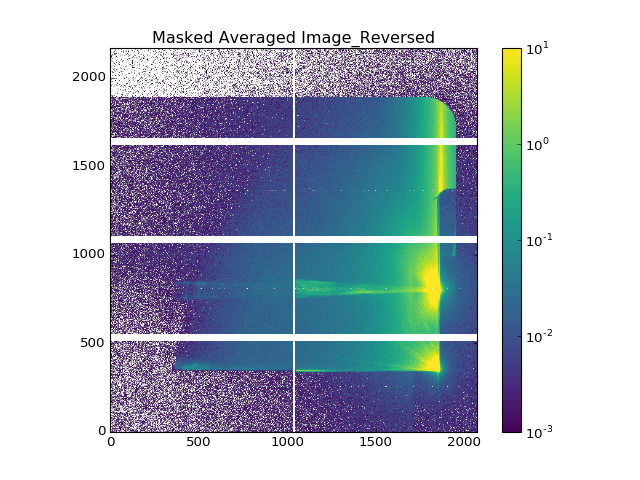

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)


## Get the approximate center and see the statistic to make sure 

In [29]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4810        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## GiSAXS get q-map (qz and qr)

### Users put incident-Beam and Reflection_Beam Centers here!!!

In [1359]:
inc_x0 = 1871
inc_y0 = 339
refl_x0 = 1871
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [1268]:
inc_x0 = 1000
inc_y0 = 339
refl_x0 = 1000
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [1250]:
lamda

1.3776

In [1360]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [1361]:
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


<IPython.core.display.Javascript object>


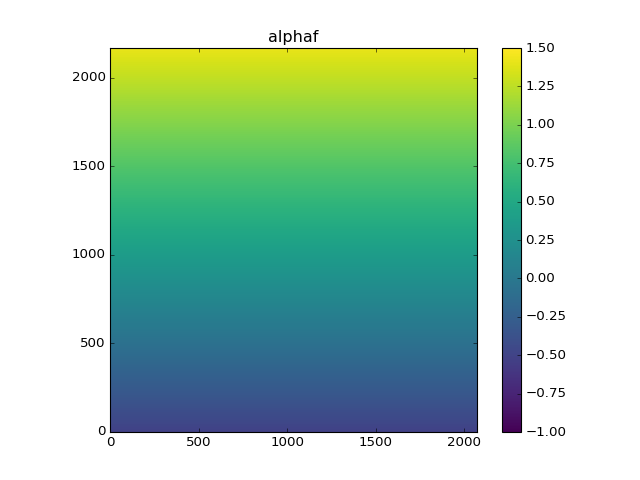

In [1362]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(alphaf*180/np.pi, origin='lower' ,cmap='viridis',vmin=-1,vmax= 1.5 )
fig.colorbar(im)
ax.set_title( 'alphaf')
plt.show()

In [1363]:
qr.shape

(2167, 2070)

In [1364]:
qr.min()

0.0

In [1365]:
qr.max()

0.13301686511414224

In [1366]:
Y,X = np.where( np.abs(qr- .1) <=.0001)

In [1367]:
X[::4].shape

(1284,)

In [916]:
qr.shape

(2167, 2070)

In [917]:
    m,M = qr.min(),qr.max()
    Nr=10
    ys,xs = qr.shape
    qs = (M-m)/xs
    qr0 = np.linspace(m,M,Nr)

In [569]:
qr0

array([ 0.        ,  0.01477965,  0.0295593 ,  0.04433896,  0.05911861,
        0.07389826,  0.08867791,  0.10345756,  0.11823721,  0.13301687])

In [598]:
def get_qmap_grid2( qr, qz, Nr=10, Nz=10 ):
    ys,xs = qr.shape
    m,M = qr.min(),qr.max()
    qsr = (M-m)/xs
    qr0 = np.linspace(m,M,Nr, endpoint=True)
    
    mz,Mz = qz.min(),qz.max()
    qsz = (Mz-mz)/ys
    qz0 = np.linspace(mz,Mz,Nz, endpoint=True)
    
    grid_qr ={}
    grid_qz ={}
    
    for i  in range(Nz):        
        Y,X = np.where( np.abs(qz- qz0[i]) <= qsz )
        #print (qr0[i], len(Y) )
        if len(Y)!=0:
            sub = int(len(Y)/10)
            grid_qz[i] =[Y[::sub], X[::sub] ]
        else:
            grid_qz[i] = []
            
            
    for i  in range(Nr):        
        Y,X = np.where( np.abs(qr- qr0[i]) <= qsr )
        #print (qr0[i], len(Y) )
        if len(Y)!=0:
            sub = int(len(Y)/10)
            grid_qr[i] =[Y[::sub], X[::sub] ]
        else:
            grid_qr[i] = []
    return grid_qr,grid_qz
        
    
    

In [639]:
def get_qmap_grid2( qr, qz, Nr=10, Nz=10 ):
    ys,xs = qr.shape
    m,M = qr.min(),qr.max()
    qsr = (M-m)/xs
    qr0 = np.linspace(m,M,Nr, endpoint=True)
    
    mz,Mz = qz.min(),qz.max()
    qsz = (Mz-mz)/ys
    qz0 = np.linspace(mz,Mz,Nz, endpoint=True)
    
    grid_qr ={}
    grid_qz ={}
    
    for i  in range(Nz):        
        Y,X = np.where( np.abs(qz- qz0[i]) <= qsz )
        #print (qz0[i], len(Y) )
        if len(Y)!=0:
            sub = int(len(Y)/7)
            grid_qz[i] =[Y[::sub], X[::sub] ]
        else:
            grid_qz[i] = []
            
            
    for i  in range(Nr):        
        Y,X = np.where( np.abs(qr- qr0[i]) <= qsr )
        #print (qr0[i], len(Y) )
        if len(Y)!=0:
            sub = int(len(Y)/7)
            grid_qr[i] =[Y[::sub], X[::sub] ]
        else:
            grid_qr[i] = []
    return grid_qr,grid_qz

In [653]:
def get_qmap_grid( qr, qz, Nr=10, Nz=10, ls=1 ):
    ys,xs = qr.shape
    m,M = qr.min(),qr.max()
    qsr = (M-m)/xs
    qr0 = np.linspace(m,M,Nr, endpoint=True)
    
    mz,Mz = qz.min(),qz.max()
    qsz = (Mz-mz)/ys
    qz0 = np.linspace(mz,Mz,Nz, endpoint=True)
    
    grid_qr ={}
    grid_qz ={}
    
    for i  in range(Nz):        
        Y,X = np.where( np.abs(qz- qz0[i]) <= ls*qsz )         
        if len(Y)!=0:
            grid_qz[i] =[Y,X]             
        else:
            grid_qz[i] = []           
            
    for i  in range(Nr):        
        Y,X = np.where( np.abs(qr- qr0[i]) <= ls*qsr )        
        if len(Y)!=0:
            grid_qr[i] =[Y,X]  
        else:
            grid_qr[i] = []
    return grid_qr,grid_qz

In [673]:
qr_grid,qz_grid = get_qmap_grid( qr, qz, Nr=10, Nz=10, ls=10 )

In [671]:
#qr*qz

<IPython.core.display.Javascript object>


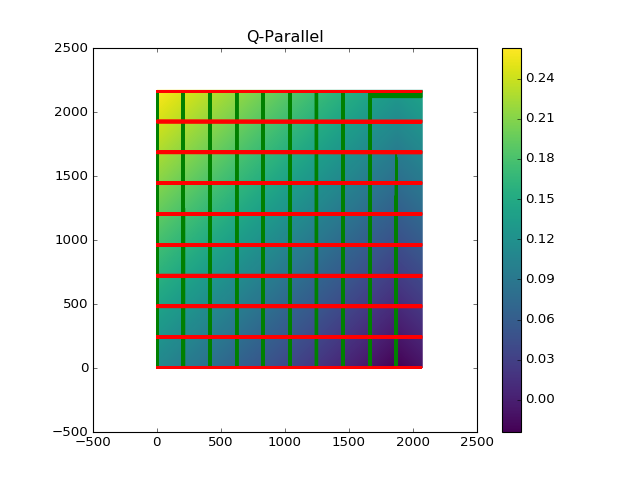

In [675]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
qrz = qr + qz
im=ax.imshow(qrz, origin='lower' ,cmap='viridis',vmin=qrz.min(),vmax= qrz.max(),) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
#ax.scatter( X[::400],Y[::400],)
for qr_key in list(qr_grid.keys()):
    if len(qr_grid[qr_key])!=0:
        y,x = qr_grid[qr_key][0], qr_grid[qr_key][1]    
        ax.plot( x,y, '-g')
for qz_key in list(qz_grid.keys()):
    if len(qz_grid[qz_key])!=0:     
        y,x = qz_grid[qz_key][0], qz_grid[qz_key][1]    
        ax.plot( x,y, '-r')
        
        
#ax.grid(True, which='both', color='r', linestyle='--')
#ax.grid(True,  color='r', linestyle='--')
#ax.grid(True,color='white')

plt.show()

<IPython.core.display.Javascript object>


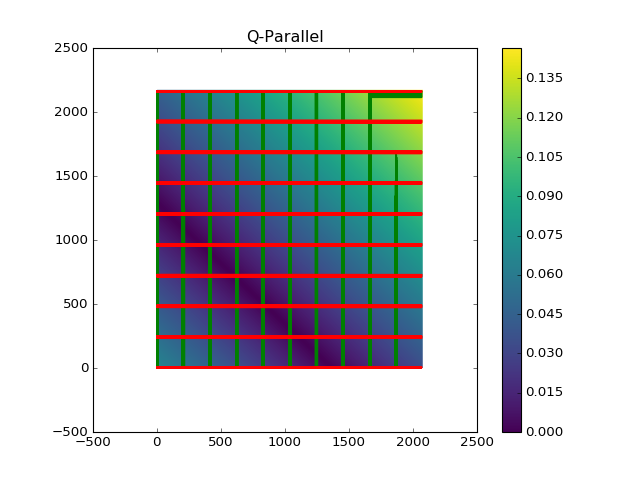

In [1187]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
#ax.scatter( X[::400],Y[::400],)

for qr_key in list(qr_grid.keys()):
    if len(qr_grid[qr_key])!=0:
        y,x = qr_grid[qr_key][0], qr_grid[qr_key][1]    
        ax.plot( x,y, '-g')
for qz_key in list(qz_grid.keys()):
    if len(qz_grid[qz_key])!=0:     
        y,x = qz_grid[qz_key][0], qz_grid[qz_key][1]    
        ax.plot( x,y, '-r')
        
        
#ax.grid(True, which='both', color='r', linestyle='--')
#ax.grid(True,  color='r', linestyle='--')
#ax.grid(True,color='white')

plt.show()

In [ ]:
#qr[np.where(qr!=0)].min()

In [1188]:
qr_edge, qr_center

(array([-0.00034553,  0.00034553,  0.00810075,  0.00879181,  0.01654703,
         0.01723808,  0.0249933 ,  0.02568436,  0.03343958,  0.03413064,
         0.04188586,  0.04257692,  0.05033214,  0.05102319,  0.05877841,
         0.05946947,  0.06722469,  0.06791575,  0.07567097,  0.07636203]),
 array([ 0.        ,  0.00844628,  0.01689256,  0.02533883,  0.03378511,
         0.04223139,  0.05067767,  0.05912394,  0.06757022,  0.0760165 ]))

In [688]:
def get_qedge( qstart,qend,qwidth,noqs,  ):
    ''' DOCUMENT make_qlist( )
    give qstart,qend,qwidth,noqs
    return a qedge by giving the noqs, qstart,qend,qwidth.
           a qcenter, which is center of each qedge 
    KEYWORD:  None    ''' 
    import numpy as np 
    qcenter = np.linspace(qstart,qend,noqs)
    #print ('the qcenter is:  %s'%qcenter )
    qedge=np.zeros(2*noqs) 
    qedge[::2]= (  qcenter- (qwidth/2)  ) #+1  #render  even value
    qedge[1::2]= ( qcenter+ qwidth/2) #render odd value
    return qedge, qcenter 

In [703]:
 get_qedge( 10,97, (97-10)/(17-1), 17 )

(array([  7.28125,  12.71875,  12.71875,  18.15625,  18.15625,  23.59375,
         23.59375,  29.03125,  29.03125,  34.46875,  34.46875,  39.90625,
         39.90625,  45.34375,  45.34375,  50.78125,  50.78125,  56.21875,
         56.21875,  61.65625,  61.65625,  67.09375,  67.09375,  72.53125,
         72.53125,  77.96875,  77.96875,  83.40625,  83.40625,  88.84375,
         88.84375,  94.28125,  94.28125,  99.71875]),
 array([ 10.    ,  15.4375,  20.875 ,  26.3125,  31.75  ,  37.1875,
         42.625 ,  48.0625,  53.5   ,  58.9375,  64.375 ,  69.8125,
         75.25  ,  80.6875,  86.125 ,  91.5625,  97.    ]))

In [921]:
qz_edge, qz_center

(array([-0.02480786, -0.02340794, -0.00769767, -0.00629774,  0.00941253,
         0.01081245,  0.02652272,  0.02792264,  0.04363291,  0.04503284,
         0.06074311,  0.06214303,  0.0778533 ,  0.07925323,  0.0949635 ,
         0.09636342,  0.11207369,  0.11347362,  0.12918389,  0.13058381]),
 array([-0.0241079 , -0.00699771,  0.01011249,  0.02722268,  0.04433288,
         0.06144307,  0.07855327,  0.09566346,  0.11277365,  0.12988385]))

In [1322]:
get_qedge?

In [1323]:
 qr_edge

array([-0.00034553,  0.00034553,  0.00810075,  0.00879181,  0.01654703,
        0.01723808,  0.0249933 ,  0.02568436,  0.03343958,  0.03413064,
        0.04188586,  0.04257692,  0.05033214,  0.05102319,  0.05877841,
        0.05946947,  0.06722469,  0.06791575,  0.07567097,  0.07636203])

In [1318]:
qr_start, qr_end, qr_num = qr.min(),qr.max(),20
qz_start, qz_end, qz_num = qz.min(),qz.max(),20

qr_edge, qr_center = get_qedge(qr_start , qr_end, ( qr_end- qr_start)/(qr_num-0.99999), qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   (qz_end - qz_start)/(qz_num- 0.99999 ) ,  qz_num )


qr_start, qr_end, qr_num = qr.min(),qr.max(),10
qz_start, qz_end, qz_num = qz.min(),qz.max(),10

qr_edge, qr_center = get_qedge(qr_start , qr_end, ( qr_end- qr_start)/(qr_num+100), qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   (qz_end - qz_start)/(qz_num+100 ) ,  qz_num )




label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)


label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))

<IPython.core.display.Javascript object>


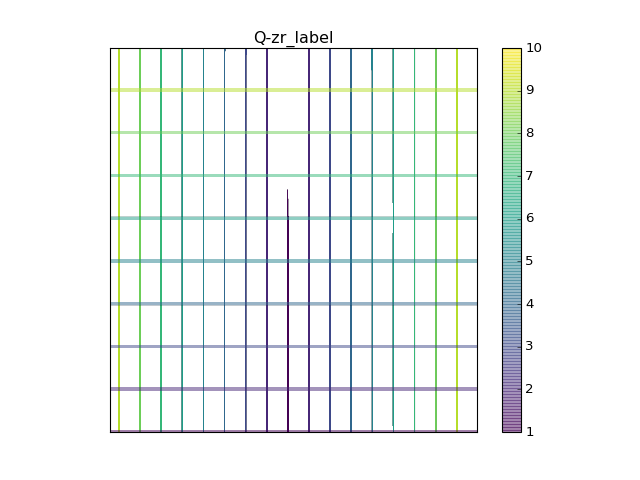

In [1319]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
#im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max() )

im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=1,vmax= None, alpha=1) 
im=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis',vmin=1,vmax= None, alpha=.5) 
fig.colorbar(im)
ax.set_title( 'Q-zr_label')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.set_yticklabels([0.0, 2.5, 3.14, 4.0, 5.2, 7.0])

plt.show()

In [904]:
import skxray.core.roi as roi

In [779]:
from  xray_vision.mpl_plotting.roi import show_label_array

In [831]:
 import matplotlib as mpl

In [922]:
qr_center

array([ 0.        ,  0.00844628,  0.01689256,  0.02533883,  0.03378511,
        0.04223139,  0.05067767,  0.05912394,  0.06757022,  0.0760165 ])

<IPython.core.display.Javascript object>


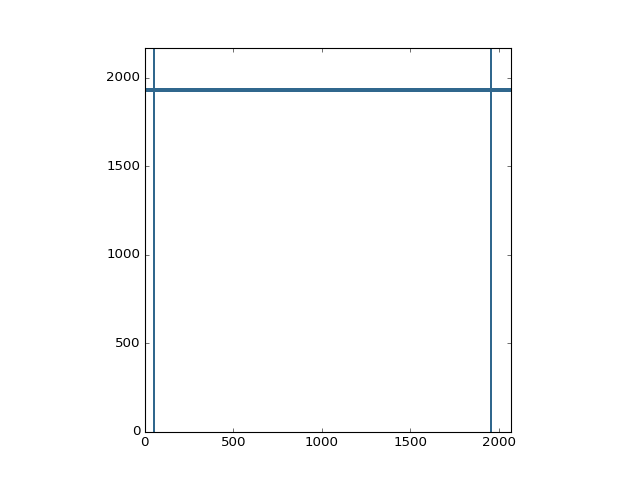

In [1327]:
fig, ax = plt.subplots()
imr=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis', vmin=8.5,vmax= None )#,interpolation='nearest',) 
imz=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis', vmin=8.5,vmax= None )#,interpolation='nearest',) 

<IPython.core.display.Javascript object>


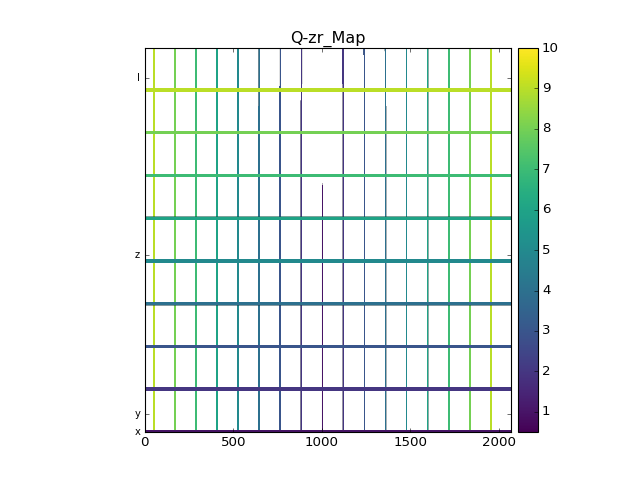

In [1324]:
fig, ax = plt.subplots()
imr=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis', vmin=.5,vmax= None )#,interpolation='nearest',) 
imz=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis', vmin=.5,vmax= None )#,interpolation='nearest',) 
caxr = fig.add_axes([0.81, 0.1, 0.03, .8])  #x,y, width, heigth
#caxz = fig.add_axes([0.91, 0.1, 0.03, .8])
cba = plt.colorbar(imr, cax=caxr    ) 
#cbb = plt.colorbar(imz, cax=caxz  ) #,  orientation='horizontal') 
#cba.set_label('qr')
#cbb.set_label('qz')

ax.set_title( 'Q-zr_label')
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)

ax.set_yticks([0.0, 2.5, 3.14, 4.0, 5.2, 7.0])
yticks =  [0.0, 2.5, 3.14, 4.0, 5.2, 7.0]

ax.set_yticks([0.0, 100,1000,2000])
yticks =  ['x','y','z','l']


#plt.xticks(xticks, fontsize=12)
#yticks = np.arange(10)
#plt.gca().set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=9)

ax.set_title( 'Q-zr_Map')
plt.show()

In [949]:
qr[label_array_qr==10].mean()

0.07587240613981687

In [960]:
xticks_label =  [ qr[label_array_qr==i].mean() for i in range( 1, len(qr_center) + 1 ) ]

In [1003]:
xticks_label

[0.00018696626904560648,
 0.0084346139787186813,
 0.016893116841698048,
 0.025351469278767226,
 0.033780109239869731,
 0.042210971214406937,
 0.050668952703481686,
 0.059129740411648611,
 0.067590165639447794,
 0.07587240613981687]

In [991]:
label_array_qr==1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [995]:
 np.where( label_array_qr==2 )[1]

array([ 877,  878,  879, ..., 1120, 1121, 1122])

In [996]:
np.where( label_array_qr==1 )[1]

array([ 996,  997,  998, ..., 1000, 1000, 1000])

In [997]:
np.where( label_array_qr==1 )[1].mean()

1000.0

In [998]:
np.where( label_array_qr==2 )[1].mean()

1000.0

In [999]:
len(np.where( label_array_qr==2 )[1])

43156

In [1055]:
ind = np.where( label_array_qr==2 )[1]

In [1056]:
ind1 = ind[np.where(ind < inc_x0)[0]]

In [1057]:
ind1

array([877, 878, 879, ..., 885, 886, 887])

In [1058]:
ind[np.where(ind> inc_x0)[0]]

array([1114, 1115, 1116, ..., 1120, 1121, 1122])

In [1046]:
inc_x0

1000

In [1002]:
np.where( label_array_qr==2 )[1][:int(43156/4)]

array([877, 878, 879, ..., 883, 884, 885])

In [977]:
zticks = [ int( np.where( label_array_qz==i )[0].mean() ) for i in range( 1, len(qz_center) + 1 ) ]

In [1073]:
np.unique( label_array_qr )[1:]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [1086]:
def get_qr_tick_label(  label_array_qr, inc_x0):
    rticks =[]
    rticks_label = []
    num =  len( np.unique( label_array_qr ) )
    for i in range( 1, num   ):
        ind =  np.where( label_array_qr==i )[1]
        tick = round( qr[label_array_qr==i].mean(),2)
        if ind[0] < inc_x0 and ind[-1]>inc_x0:
             
            mean1 = int( (ind[np.where(ind < inc_x0)[0]]).mean() )
            mean2 = int( (ind[np.where(ind > inc_x0)[0]]).mean() )
            rticks.append( mean1)
            rticks.append(mean2)
             
            rticks_label.append( tick )
            rticks_label.append( tick )
             
        else:    
            mean = int( ind.mean() )
            rticks.append(mean)
            rticks_label.append( tick )
    #print (rticks)
        
    return np.array(rticks), np.array(rticks_label)
    
def get_qz_tick_label(  label_array_qz):    
    num =  len( np.unique( label_array_qz ) )
    zticks = np.array( [ int( np.where( label_array_qz==i )[0].mean() ) for i in range( 1,num ) ])
    zticks_label = np.array( [ round( qz[label_array_qz==i].mean(),2) for i in range( 1, num ) ])
    return  zticks,zticks_label 

In [1274]:
def get_qr_tick_label(  label_array_qr, inc_x0):
    rticks =[]
    rticks_label = []
    num =  len( np.unique( label_array_qr ) )    
    key =0
    for i in range( 1, num   ):
        ind =  np.where( label_array_qr==i )[1]
        tick = round( qr[label_array_qr==i].mean(),2)
        
        if ind[0] < inc_x0 and ind[-1]>inc_x0:
             
            mean1 = int( (ind[np.where(ind < inc_x0)[0]]).mean() )
            mean2 = int( (ind[np.where(ind > inc_x0)[0]]).mean() )
            rticks.append( mean1)
            rticks.append(mean2)
            
            rticks_label.append( tick )
            rticks_label.append( tick )
            
            
             
        else:    
            mean = int( ind.mean() )
            rticks.append(mean)
            rticks_label.append( tick )
    #print (rticks)
        
    return np.array(rticks), np.array(rticks_label)
    
def get_qz_tick_label(  label_array_qz):    
    num =  len( np.unique( label_array_qz ) )
    zticks = np.array( [ int( np.where( label_array_qz==i )[0].mean() ) for i in range( 1,num ) ])
    zticks_label = np.array( [ round( qz[label_array_qz==i].mean(),2) for i in range( 1, num ) ])
    return  zticks,zticks_label 

In [1275]:
res = get_qr_tick_label(label_array_qr, inc_x0)

TypeError: 'list' object is not callable

In [1101]:
len(res[0])

18

In [1102]:
len(res[1])

18

In [1252]:
l1, l2 = zip(*sorted(  zip( *get_qr_tick_label(label_array_qr, inc_x0) ))  )

In [1081]:
get_qz_tick_label(label_array_qz)

(array([   4,  240,  481,  721,  962, 1203, 1443, 1684, 1925, 2161]),
 array([-0.02, -0.01,  0.01,  0.03,  0.04,  0.06,  0.08,  0.1 ,  0.11,  0.13]))

In [1085]:
rticks,rticks_label

(array([1000,  881,  881,  762,  762,  643,  643,  525,  525,  406,  406,
         287,  287,  168,  168,   49,   49, 2067]),
 array([ 0.  ,  0.01,  0.01,  0.02,  0.02,  0.03,  0.03,  0.03,  0.03,
         0.04,  0.04,  0.05,  0.05,  0.06,  0.06,  0.07,  0.07,  0.08]))

In [1133]:
import copy

In [1198]:
stack = np.vstack([qr.ravel(), qz.ravel()])

In [1221]:
lims=[[np.min(qr),
                              np.max(qr)],
                             [np.min(qz),
                              np.max(qz)]]

In [1222]:
lims

[[0.0, 0.14662550256462029], [-0.071821735796922193, 0.14085133931072452]]

<IPython.core.display.Javascript object>


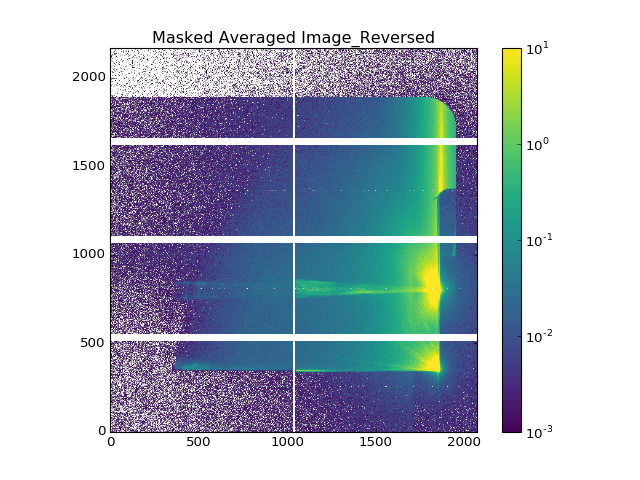

In [1276]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


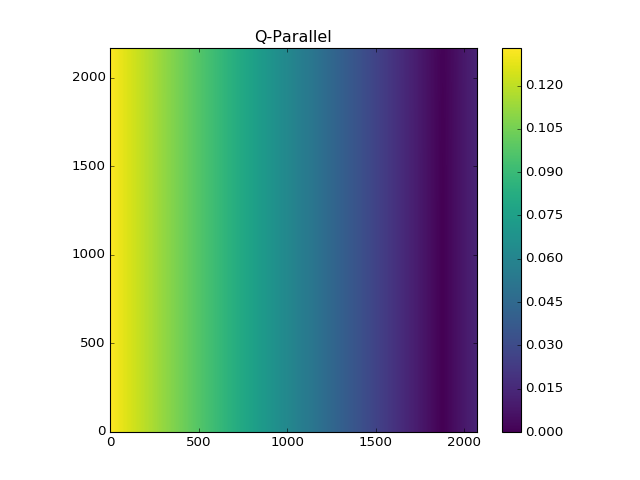

In [1368]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
#ax.scatter( X[::400],Y[::400],)

        
        
#ax.grid(True, which='both', color='r', linestyle='--')
#ax.grid(True,  color='r', linestyle='--')
#ax.grid(True,color='white')

plt.show()

In [1283]:
np.histogram2d?

In [1284]:
qz.shape

(2167, 2070)

In [1296]:
hist = np.histogram2d(qz.ravel(), 
                      qr.ravel(), 
                      weights=avg_imgmr.ravel(), 
                      bins=[ 2167/2, 2070/2  ],
                      range=[[np.min(qz),
                              np.max(qz)],
                             [np.min(qr),
                              np.max(qr)]])

In [1297]:
hist[0].shape

(1083, 1035)

In [1301]:
hist[2][-1], hist[2][0], hist[1][-1], hist[1][0]

(0.076016497512838205, 0.0, 0.12988384851170062, -0.024107901184751101)

In [1308]:
hist[2]

array([  0.00000000e+00,   7.34458913e-05,   1.46891783e-04, ...,
         7.58696057e-02,   7.59430516e-02,   7.60164975e-02])

In [1306]:
hist[0].shape

(1083, 1035)

In [1299]:
plt.close('all')

<IPython.core.display.Javascript object>


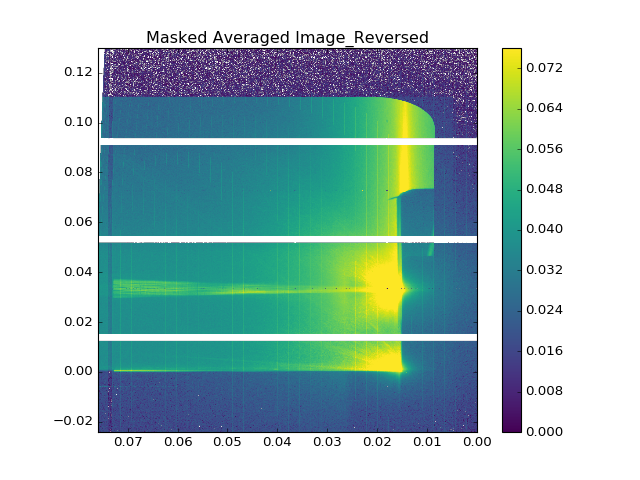

In [1304]:
fig, ax = plt.subplots()
ax.imshow(hist[0], cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1), aspect =.5,
           extent=(hist[2][-1], hist[2][0], hist[1][0], hist[1][-1]))

ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


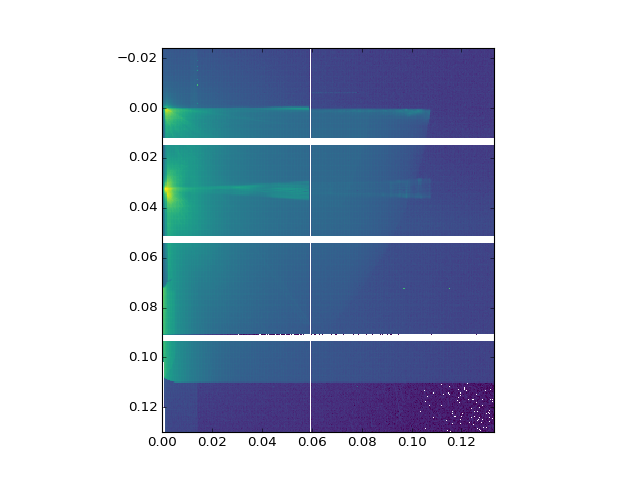

In [1255]:
fig, ax = plt.subplots()
ax.imshow(np.log(hist[0]), 
          cmap='viridis', interpolation='nearest', extent=(hist[2][0], hist[2][-1], hist[1][-1], hist[1][0]))

In [1212]:
np.histogram2d?

In [1310]:
fig, ax = plt.subplots()


im=ax.imshow(qr+qz, origin='lower' ,cmap='viridis' ) 
imr=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis', vmin=.5,vmax= None,alpha=.5 )#,interpolation='nearest',) 
imz=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis', vmin=.5,vmax= None )#,interpolation='nearest',) 

caxr = fig.add_axes([0.81, 0.1, 0.03, .8])  #x,y, width, heigth
#caxz = fig.add_axes([0.91, 0.1, 0.03, .8])
cba = fig.colorbar(im, cax=caxr    ) 
#cbb = plt.colorbar(imz, cax=caxz  ) #,  orientation='horizontal') 
ax.set_xlabel(r'$q_r$', fontsize=18)
ax.set_ylabel(r'$q_z$',fontsize=18)

ax.set_title( 'Q-zr_label')
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#zticks = np.array( [ int( np.where( label_array_qz==i )[0].mean() ) for i in range( 1, len(qz_center) + 1 ) ])
#zticks_label = np.array( [ round( qz[label_array_qz==i].mean(),2) for i in range( 1, len(qz_center) + 1 ) ])
zticks,zticks_label  = get_qz_tick_label(label_array_qz)
#rticks,rticks_label  = get_qr_tick_label(label_array_qr,inc_x0)

rticks,rticks_label = zip(*sorted(  zip( *get_qr_tick_label(label_array_qr, inc_x0) ))  )

ax.set_yticks( zticks[::1] )
yticks =  zticks_label[::1]
ax.set_yticklabels(yticks, fontsize=9)

stride = int(len(rticks)/5)
ax.set_xticks( rticks[::stride] )
xticks =  rticks_label[::stride]
ax.set_xticklabels(xticks, fontsize=9)
 

ax.set_title( 'Q-zr_Map', y=1.03,fontsize=18)
plt.show()

<IPython.core.display.Javascript object>

TypeError: 'list' object is not callable

In [1311]:
get_qr_tick_label(label_array_qr, inc_x0)

TypeError: 'list' object is not callable

In [982]:
zticks_label =  [ round( qz[label_array_qz==i].mean(),2) for i in range( 1, len(qz_center) + 1 ) ]

In [989]:
xticks_label

[0.00018696626904560648,
 0.0084346139787186813,
 0.016893116841698048,
 0.025351469278767226,
 0.033780109239869731,
 0.042210971214406937,
 0.050668952703481686,
 0.059129740411648611,
 0.067590165639447794,
 0.07587240613981687]

In [1011]:
np.where(  abs(qz - qz_center[6]) <=.0002 )

(array([1441, 1441, 1441, ..., 1446, 1446, 1446]),
 array([   0,    1,    2, ..., 2067, 2068, 2069]))

In [1043]:
np.where(  abs(qr - qr_center[1]) <=.0002 )

(array([   0,    0,    0, ..., 2166, 2166, 2166]),
 array([ 879,  880,  881, ..., 1118, 1119, 1120]))

In [1018]:
qr_center

array([ 0.        ,  0.00844628,  0.01689256,  0.02533883,  0.03378511,
        0.04223139,  0.05067767,  0.05912394,  0.06757022,  0.0760165 ])

In [1041]:
def get_qr_tick_label(qr,qr_center, qs = 1e-8):
    rticks =[]
    rticks_label = []
    #ind =[]
    
    for qrc in  qr_center:
        qs_=qs
        ind=[]
        print (qrc)
        while len(ind)==0:
            #print (qs_)
            ind =  np.where( abs(qr - qrc) <= qs_ )[0]
            qs_ *= 10
        print (ind)
        mean = ind.mean()
        #if abs(ind[0] - mean)>=10:
            #rticks.append( )

In [1044]:
get_qr_tick_label(qr,qr_center, qs =1e-4)

0.0
[  90   91   92 ..., 1058 1059 1060]
0.00844627750143
[   0    0    0 ..., 2166 2166 2166]
0.0168925550029
[   0    0    0 ..., 2166 2166 2166]
0.0253388325043
[   0    0    0 ..., 2166 2166 2166]
0.0337851100057
[   0    0    0 ..., 2166 2166 2166]
0.0422313875071
[   0    0    0 ..., 2166 2166 2166]
0.0506776650086
[   0    0    0 ..., 2166 2166 2166]
0.05912394251
[   0    0    0 ..., 2166 2166 2166]
0.0675702200114
[   0    0    0 ..., 2166 2166 2166]
0.0760164975128
[   0    0    1 ..., 2165 2166 2166]


In [1039]:
np.where(  abs(qr - qr_center[6]) <=.0002 )

(array([   0,    0,    0, ..., 2166, 2166, 2166]),
 array([ 285,  286,  287, ..., 1713, 1714, 1715]))

In [1013]:
qr.shape

(2167, 2070)

In [1004]:
qz_center

array([-0.0241079 , -0.00699771,  0.01011249,  0.02722268,  0.04433288,
        0.06144307,  0.07855327,  0.09566346,  0.11277365,  0.12988385])

In [983]:
zticks_label

[-0.02,
 -0.01,
 0.01,
 0.029999999999999999,
 0.040000000000000001,
 0.059999999999999998,
 0.080000000000000002,
 0.10000000000000001,
 0.11,
 0.13]

In [984]:
zticks

[4, 240, 481, 721, 962, 1203, 1443, 1684, 1925, 2161]

In [965]:
np.where( label_array_qr== 2 )[1].mean()

1000.0

In [967]:
np.where( label_array_qr== 9 )

(array([   0,    0,    0, ..., 2166, 2166, 2166]),
 array([  45,   46,   47, ..., 1953, 1954, 1955]))

In [970]:
label_array_qr

array([[ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       ..., 
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10]])

In [961]:
xticks = [ np.where( label_array_qr==i )[1].mean() for i in range( 1, len(qr_center) + 1 ) ]

In [962]:
xticks

[1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 2067.0]

In [935]:
yticks

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [1162]:
stack = np.dstack([label_array_qr-4.5, label_array_qz, qr+qz])

In [1163]:
stack.shape

(2167, 2070, 3)

<IPython.core.display.Javascript object>


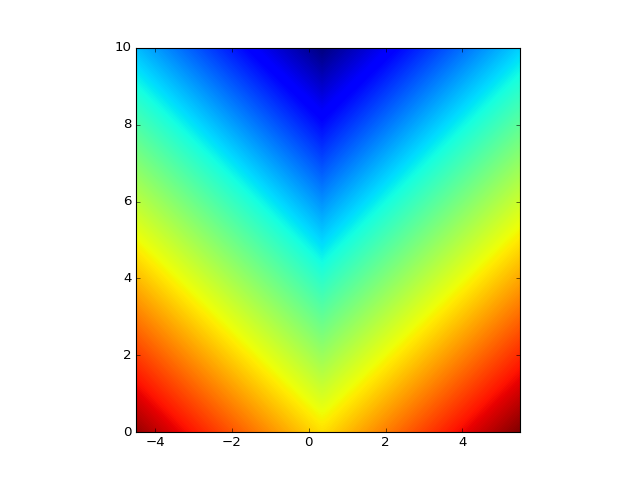

In [1168]:
fig, ax = plt.subplots()
xmin = np.min(stack[:,:,0])
ymin = np.min(stack[:,:,1])
xmax = np.max(stack[:,:,0])
ymax = np.max(stack[:,:,1])
zmin = np.min(stack[:,:,2])
zmax = np.max(stack[:,:,2])
ax.imshow(stack[:,:,2],extent=(xmin, xmax, ymin, ymax), vmin=zmin, vmax=zmax)

<IPython.core.display.Javascript object>


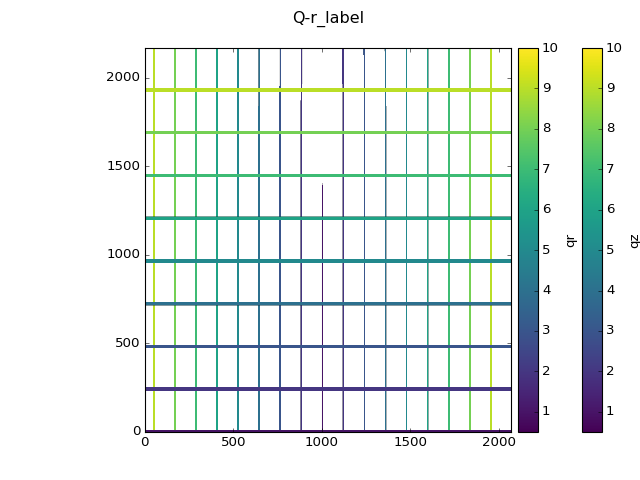

In [1316]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
#im=show_label_array(ax, label_array_qz, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
#im2=show_label_array(ax, label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )

imr=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis', vmin=.5,vmax= None )#,interpolation='nearest',) 
imz=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis', vmin=.5,vmax= None )#,interpolation='nearest',) 
#ax.set_aspect('equal')

#im3=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),alpha=.2) 
#fig.colorbar(imr,orientation='horizontal')
#fig.colorbar(imz,orientation='vertical')

#cax,kw = mpl.colorbar.make_axes( ax )

#cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])

caxr = fig.add_axes([0.81, 0.1, 0.03, .8])  #x,y, width, heigth

caxz = fig.add_axes([0.91, 0.1, 0.03, .8])
cba = plt.colorbar(imr, cax=caxr    ) 
cbb = plt.colorbar(imz, cax=caxz  ) #,  orientation='horizontal') 
cba.set_label('qr')
cbb.set_label('qz')
#imr.colorbar( orientation='horizontal')
#imz.colorbar( orientation='vertical')
#fig.tight_layout()  
ax.set_title( 'Q-r_label',y=1.05)
plt.show()

In [1313]:
label_array_qz

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ..., 
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]])

In [1315]:
label_array_qr

array([[ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       ..., 
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10],
       [ 0,  0,  0, ..., 10, 10, 10]])

<IPython.core.display.Javascript object>


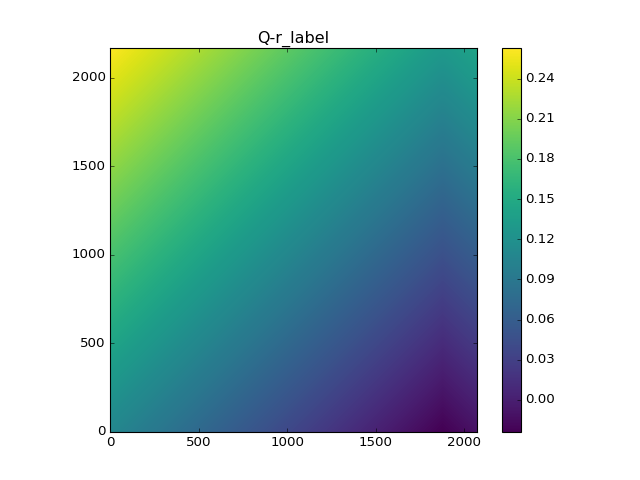

In [1260]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
#im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
im=ax.imshow(qr+qz, origin='lower' ,cmap='viridis' ) 
#im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= #qz.max(),alpha =0.5) 

fig.colorbar(im)
ax.set_title( 'Q-r_label')
plt.show()

<IPython.core.display.Javascript object>


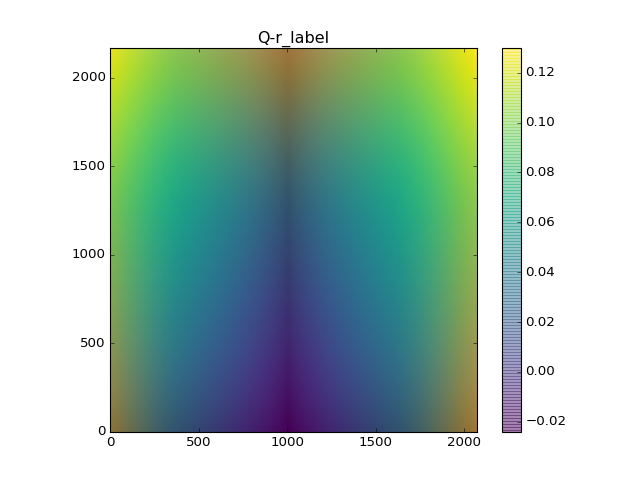

In [1126]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
#im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),alpha =1) 
im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max(),alpha =0.5) 

fig.colorbar(im)
ax.set_title( 'Q-r_label')
plt.show()

<IPython.core.display.Javascript object>


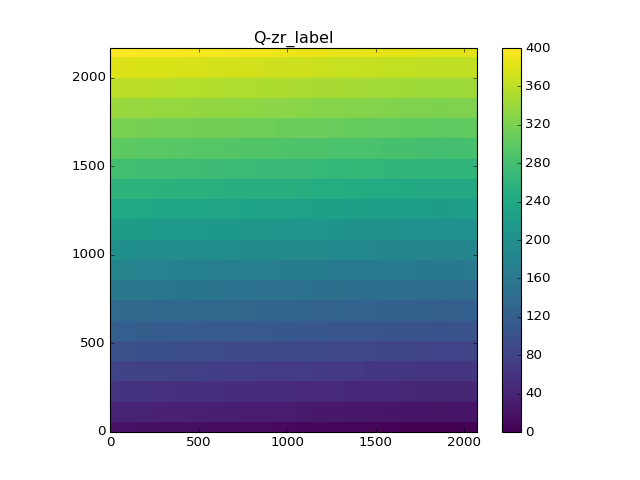

In [723]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qzr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-zr_label')
plt.show()

<IPython.core.display.Javascript object>


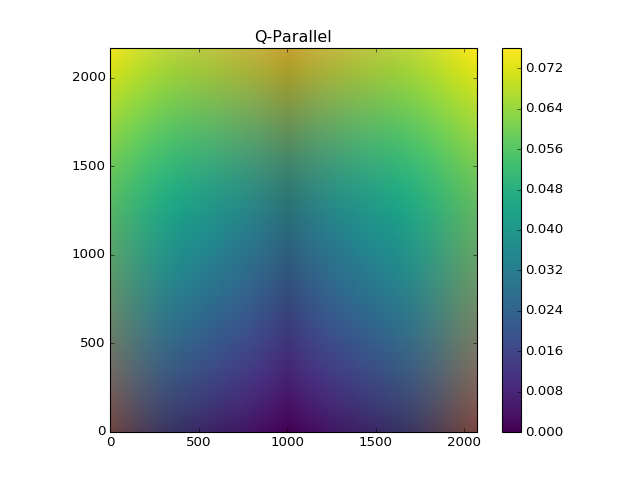

In [1124]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
#im=plt.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),alpha=1) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
    
im=plt.imshow(qr, origin='lower' , cmap='viridis', vmin=qr.min(),vmax= qr.max(),alpha=1) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )    
plt.hold(True)
im2=plt.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max(),alpha=.7,) 
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
 

plt.show()

<IPython.core.display.Javascript object>


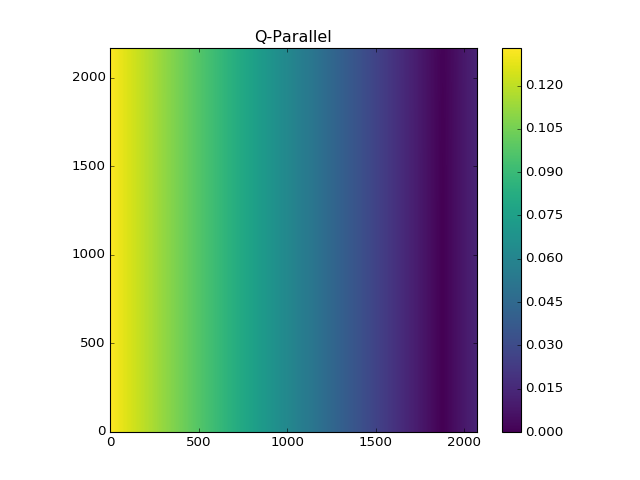

In [1261]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max(),) 
             #extent= [ qr.min(),qr.max(),qr.min(),qr.max()] )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
#ax.scatter( X[::400],Y[::400],)

        
        
#ax.grid(True, which='both', color='r', linestyle='--')
#ax.grid(True,  color='r', linestyle='--')
#ax.grid(True,color='white')

plt.show()

<IPython.core.display.Javascript object>


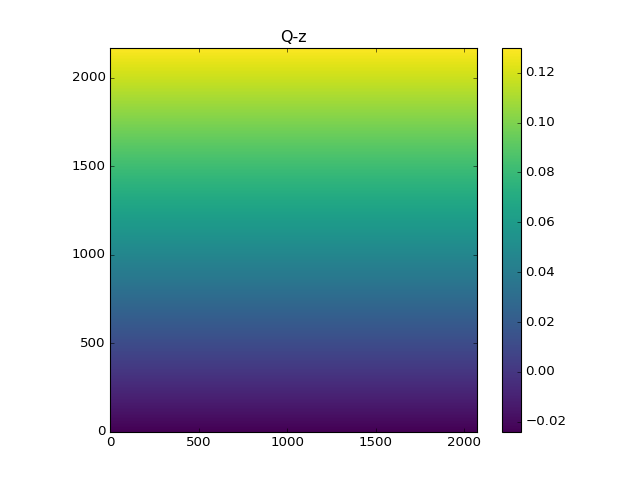

In [36]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max() )
fig.colorbar(im)
ax.set_title( 'Q-z')
plt.show()

# Get q||-intensity

## Users put cuts here!!!

<IPython.core.display.Javascript object>


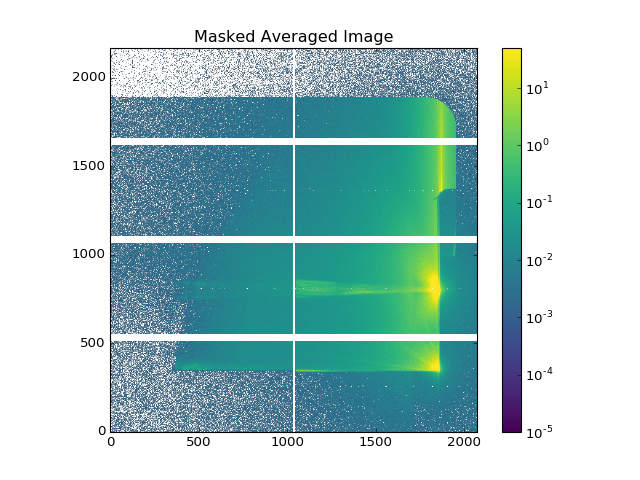

In [37]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgr, cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=.5e2 ) )
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

In [1369]:
vert_rect = ( ( 850, 0, 980- 850, 1600-0) , ( 570, 0, 700- 570, 1600-0) )    #(y,x, hight, wdith)

In [1382]:
qz[570]

array([ 0.0164279,  0.0164279,  0.0164279, ...,  0.0164279,  0.0164279,
        0.0164279])

In [1370]:
new_mask = np.ones_like( avg_imgr)
new_mask[ :, 1020:1045] =0

<IPython.core.display.Javascript object>


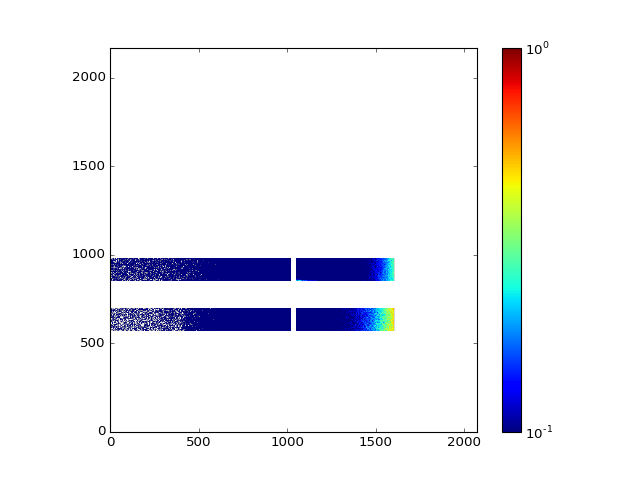

<IPython.core.display.Javascript object>


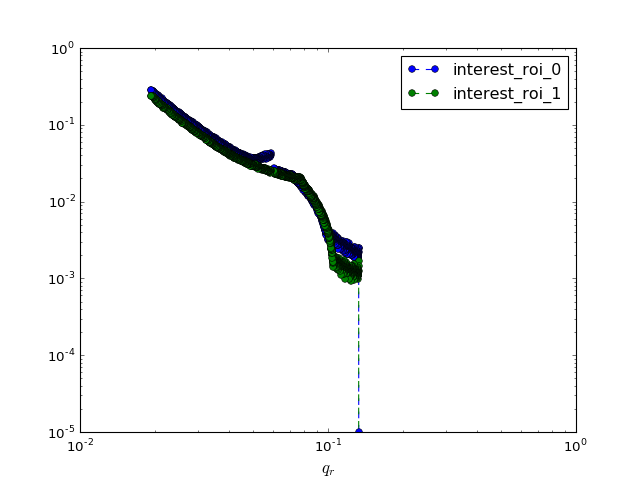

0 (850, 0, 130, 1600)
1 (570, 0, 130, 1600)


In [1371]:
get_qr_intensity( qr, avg_imgr, vert_rect, mask=new_mask, show_roi=True)

## User gives the interested Qz,Qr here!!! 

In [1372]:
qz_start = qz[670,0]
qz_end = qz[950,0]
qz_num= 2


qr_start =  qr[600,1700]
qr_end = qr[600,0]
qr_num = 15

## Create label array (Qz, Qr, Qzr boxes)

In [1373]:
qr_edge, qr_center = get_qedge(qr_start , qr_end, ( qr_end- qr_start)/qr_num, qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   (qz_end - qz_start)/(qz_num -0) , qz_num )

label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))

In [1374]:
num_qz,num_qr,num_qzr

(2, 15, 30)

<IPython.core.display.Javascript object>


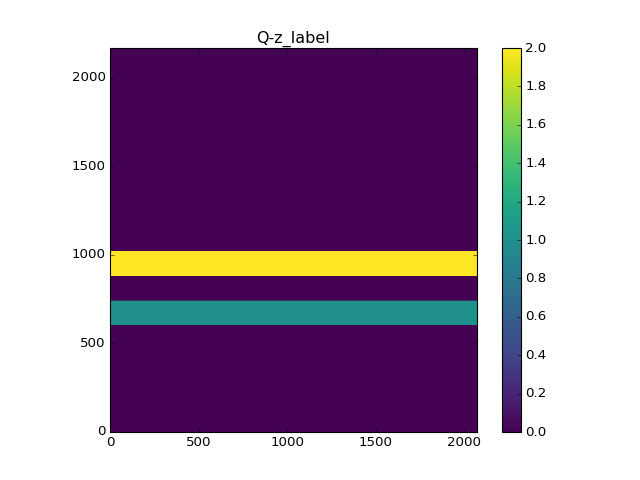

In [1375]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-z_label')
plt.show()

<IPython.core.display.Javascript object>


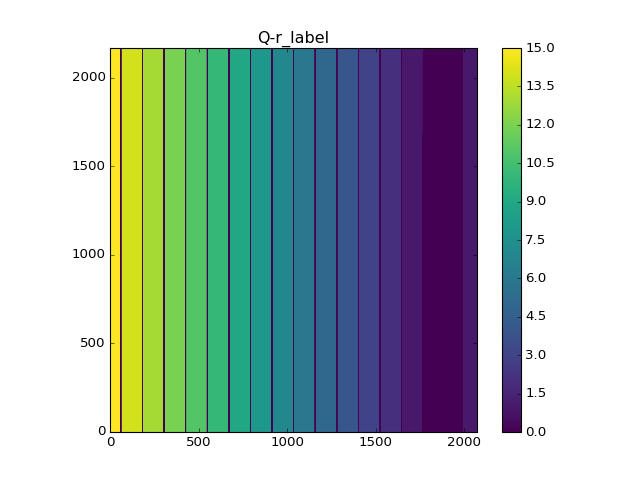

In [1376]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-r_label')
plt.show()

## Extract the labeled array

In [1377]:
boxes = label_array_qzr 
box_maskr = boxes*maskr


In [1378]:
qind, pixelist = roi.extract_label_indices(   box_maskr  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]

## Number of pixels in each q ring

In [1379]:
nopr

array([27383, 15846, 15707, 15707, 15846, 15290, 15845, 15697, 15706,
       15846, 15703, 15843, 15707, 15846,  7922, 27776, 16074, 15933,
       15933, 16074, 15508, 16074, 15933, 15933, 16039, 15933, 16074,
       15933, 16074,  8037])

## plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


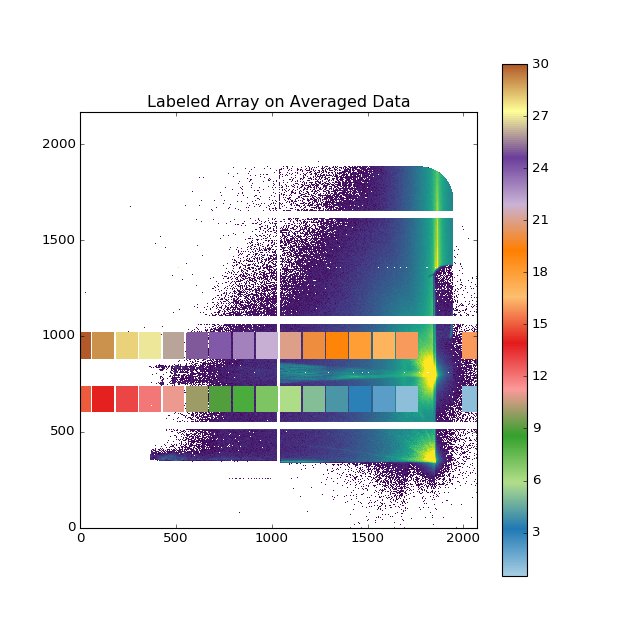

In [1380]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im,im_label = show_label_array_on_image(axes, avg_imgr, box_maskr, imshow_cmap='viridis',
                        cmap='Paired',
                         vmin=0.01, vmax=30. ,  origin="lower")
#rwidth = 200 

#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])

#fig.colorbar(im)
fig.colorbar(im_label)
plt.show()

##  Kymograph(waterfall plot) of the max-intensity ring

In [54]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, maskr)    

In [55]:
t0 = time.time()
data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
run_time(t0)

Total time: 4.40 min


### users put the number of ring with max intensity here

In [57]:
max_inten_ring =2

In [58]:
pixelist_qi =  np.where( qind == max_inten_ring )[0]         
data_pixel_qi = data_pixel[:,pixelist_qi] 

In [59]:
data_pixel_qi.shape

(15000, 15846)

<IPython.core.display.Javascript object>


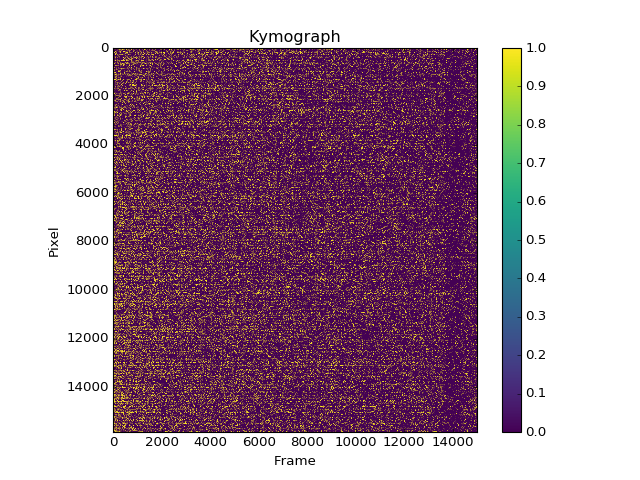

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(1.)
plt.show()

<IPython.core.display.Javascript object>


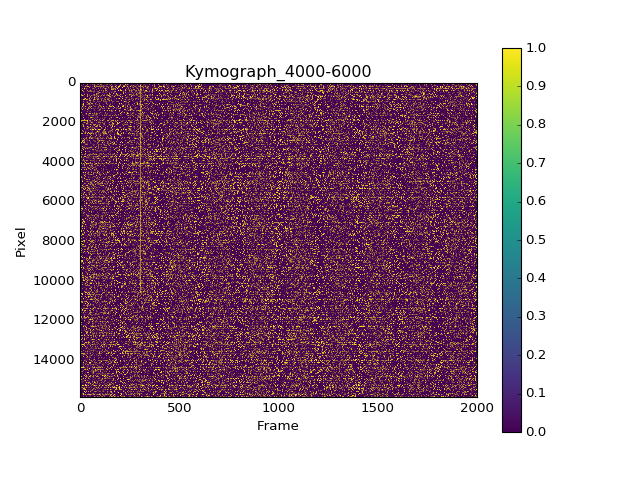

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_4000-6000')

im = ax.imshow(data_pixel_qi[4000:6000,:].T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(.1)
plt.show()

## TIme~Mean intensities for each ring

In [62]:
mean_inten = get_mean_intensity( data_pixel, qind)

<IPython.core.display.Javascript object>


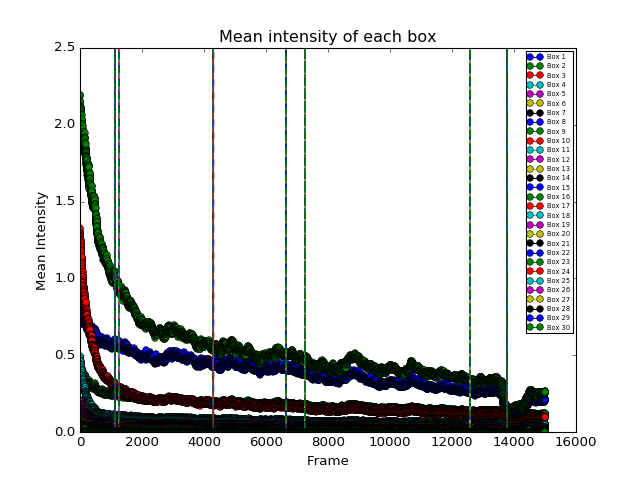

In [63]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each box")
for i in range(  num_qzr  ):
    ax.plot(times, mean_inten[i+1], '--o', label="Box "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
    ax.set_ylim(0, 2.5)
    
ax.legend( loc='best', fontsize = 6) 
plt.show()

##  Mean intensities for each ring

In [64]:
mask_data =   np.arange( len(data_pixel))  
mask_data_ = np.delete( mask_data, bad_frames)

In [ ]:
#mask_data_

In [ ]:
#mean_inten[1][:1000].mean()

In [65]:
K_mean = np.array( [mean_inten[i][mask_data_].mean() for i in  list(mean_inten.keys() )] )

In [ ]:
K_mean

## XSVS analysis

#### Get max count number

In [66]:
max_cts = data_pixel[mask_data_].max()
max_cts

1180.0

In [67]:
data_pixel[1000].max()

23.0

In [68]:
max_cts =60

In [69]:
data_pixel.shape

(15000, 483222)

In [70]:
#max_cts = data_pixel.max()
#max_cts

In [71]:
%run speckle.py

### Users provide frame info (start-frame and end-frame) for analysis

In [72]:
good_start = 0
good_end =  3000# if using Nimg, then calculate all the images

good_end =    Nimg  #hen calculate all the images
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask) 

In [450]:
good_start = 4000
good_end =  8000# if using Nimg, then calculate all the images

#good_end =    Nimg  #hen calculate all the images
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask)

In [451]:
len(imgs_)

4000

In [452]:
time_steps = utils.geometric_series(2,   len(imgs_)   ) [:-3]
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256]

In [453]:
num_times = len(time_steps)

In [454]:
spe_cts_all, std_dev = xsvs( (imgsr,), np.int_(box_maskr), timebin_num=2,
        number_of_img= len(imgs_), max_cts=int(max_cts+2), time_bin = time_steps,
                            bad_images=None, threshold = 5000 )

#bad image: 304 here!
######bad image: 2645 here!
##bad image: 3245 here!
#Total time: 6.38 min


In [455]:
spe_cts_all.shape

(9, 30)

In [ ]:
#np.save( path + 'uid_%s_spe_cts_all'%uid, spe_cts_all)

In [456]:
#np.save( path + 'uid_%s_spe_cts_%s--%s'%(uid,good_start,good_end), spe_cts_all)

In [76]:

#spe_cts_all = np.load(path + 'uid_%s_spe_cts_all.npy'%uid )

### This will provide the normalized bin edges for each integration time

In [ ]:
#Knorm_bin_edges, Knorm_bin_centers = speckle.normalize_bin_edges( len(time_steps), num_rings, K_mean, int(max_cts+2))

In [457]:
bin_edges, bin_centers, Knorm_bin_edges, Knorm_bin_centers = get_bin_edges(
      len(time_steps), num_qzr, K_mean, int(max_cts+2)  )

### Plot the results for each q box

<IPython.core.display.Javascript object>


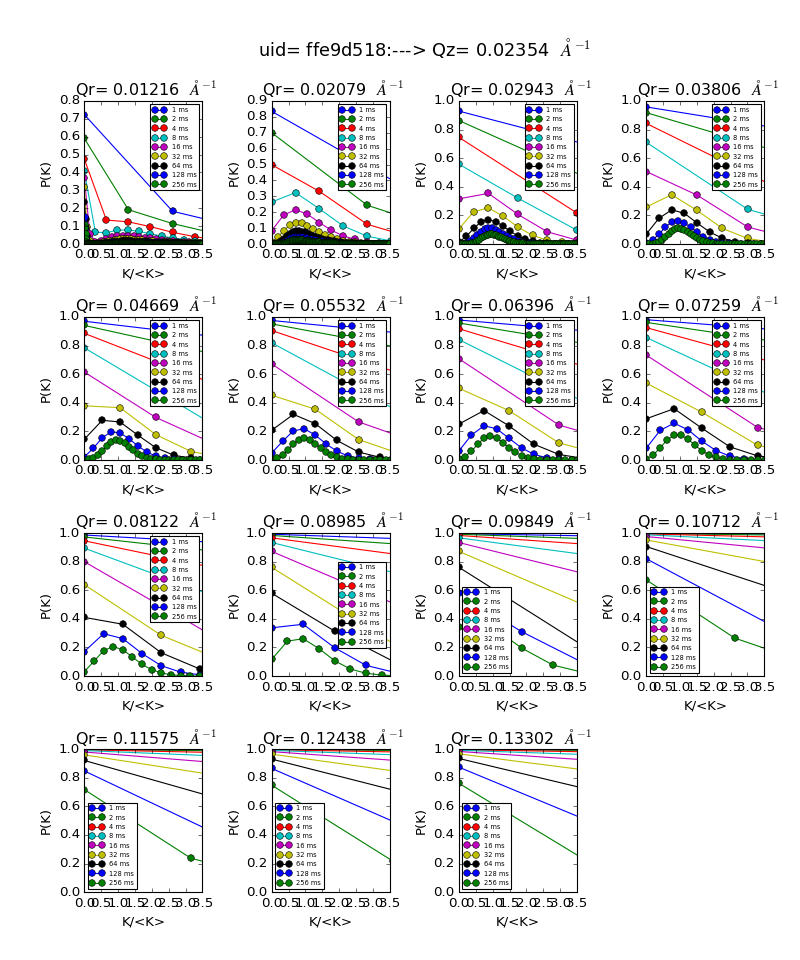

<IPython.core.display.Javascript object>


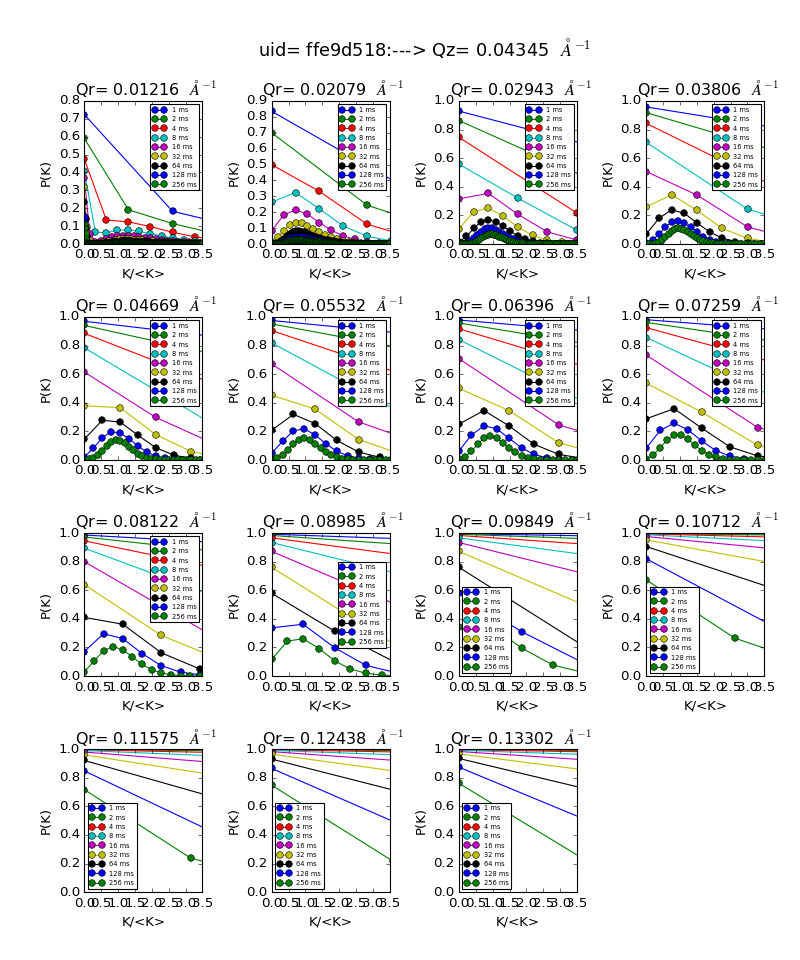

In [458]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 )        
        for j in range(len(time_steps)): 
            #if sn == 0:
            art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  



### show one q plot

<IPython.core.display.Javascript object>


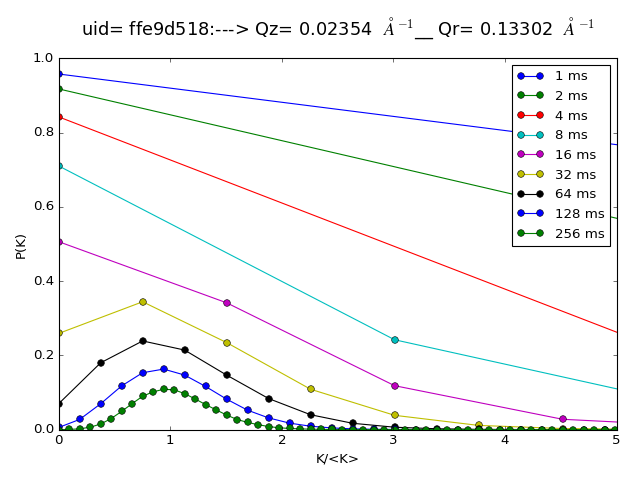

In [459]:
qz_ind =0
sn =3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 5.0)         
    axes.legend(loc='best', fontsize = 12)
        
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout()  

## Fit XSVS results

## Negative Binomaial Distribution
$P(K) =(\frac{M}{<K>})^M \frac{K ^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})$
             

## Gamma Distribution

$P(K)=\frac{\Gamma(K+M)}{\Gamma(K+1)\Gamma(M)}(\frac{M}{M+<K>})^M(\frac{<K>}{M+<K>})^K$

## Poission Distribution
$P(K) = \frac{<K>^K}{K!}\exp(-<K>)$

### Fitting with Negative Binomial and Gamma and Poisson Distribution

In [460]:
%run speckle.py

In [461]:
from lmfit import  Model
from scipy.interpolate import UnivariateSpline

#g_mod = Model(gamma_dist, indepdent_vars=['K'])
g_mod = Model( gamma_dist )
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)
dc_mod = Model(diff_mot_con_factor)

In [462]:
#gamma_dist??

## This will provide the better range to fit

In [463]:
#get_roi(data=spe_cts_all[0,3], threshold=1e-8)

## fit with Negative Binomial Function

### fit one-q first

<IPython.core.display.Javascript object>


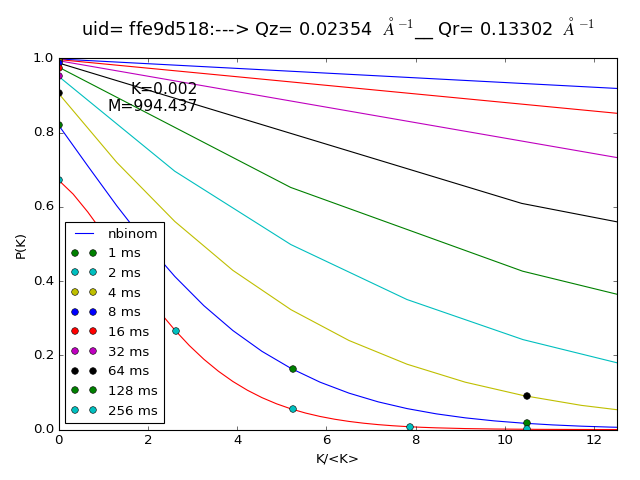

In [466]:
qz_ind =0
sn = 11

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
    
    threshold=1e-4
    M= 10
    K= -1
    trys = 1
    for trys in range(7):
         
        if M<=0 or  K <= 0:
            threshold *= 10
            trys +=1
            
            n_mod.set_param_hint('M', value = 100, min=1.0, max= 10000 ) 
            n_mod.set_param_hint('K', value = K_mean[sn] * 2**j, 
                                 min=  K_mean[sn] * 2**j/10,max=  K_mean[sn] * 2**j*10) 
            
            #print (K_mean[sn]*2**j)
            
            
            pars = n_mod.make_params()                
            
            roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)      
            result_n = n_mod.fit(spe_cts_all[j, sn][roi],
                bin_values=bin_edges[j, sn][:-1][roi], params =pars) 
            M =  result_n.best_values['M']
            K =  result_n.best_values['K']
             
        else:
            break
            
           
    M_val=M
    K_val=K
    #print (M_val,K_val)
    
    #  Using the best K and M values interpolate and get more values for fitting curve
    #if j<=3:population_N = 10000
    #else:population_N=len(Knorm_bin_edges[j, sn][:-1])
    population_N  = 500*2**j   
    
    xlim=12.5
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )      
    
    #fitx_ = fitx_
    #fitx = np.linspace(0, xlim*K_mean[sn], population_N ) 
    fity = nbinom_dist( fitx, K_val, M_val ) # M and K are fitted best values
    
    
    if j == 0:
        art, = axes.plot( fitx_[:500],fity[:500], '-',  label="nbinom")
    else:
        art, = axes.plot( fitx_[:500],fity[:500], '-')                
                
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, xlim)         
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K_val) +r'M='+'%.3f'%(M_val),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

<IPython.core.display.Javascript object>


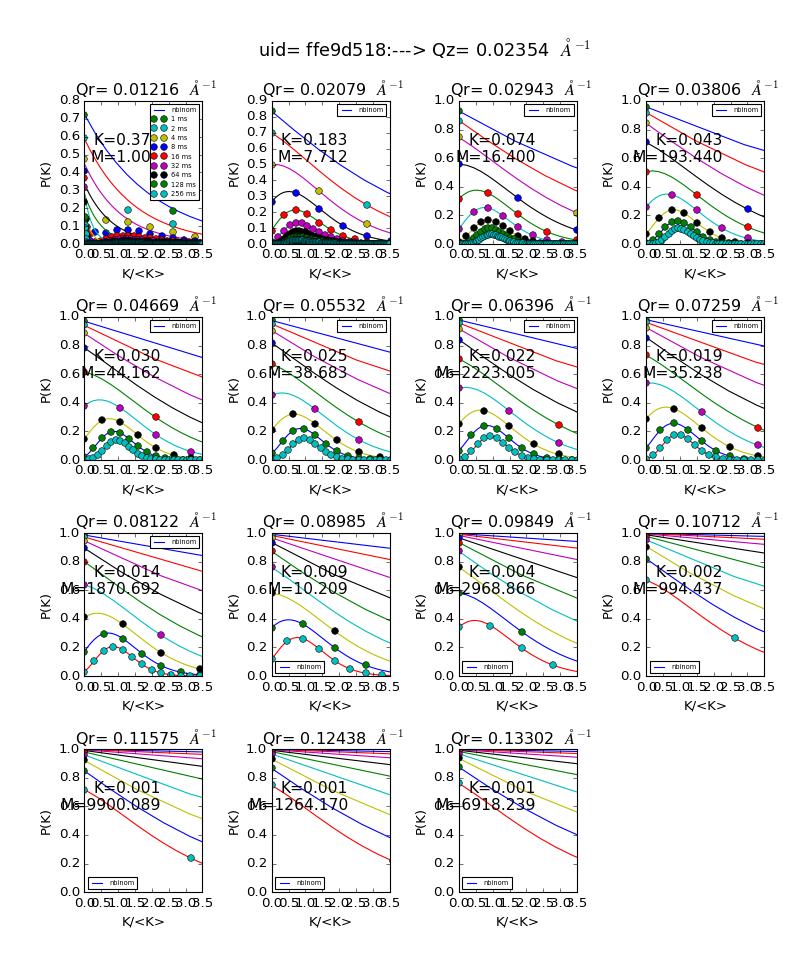

<IPython.core.display.Javascript object>


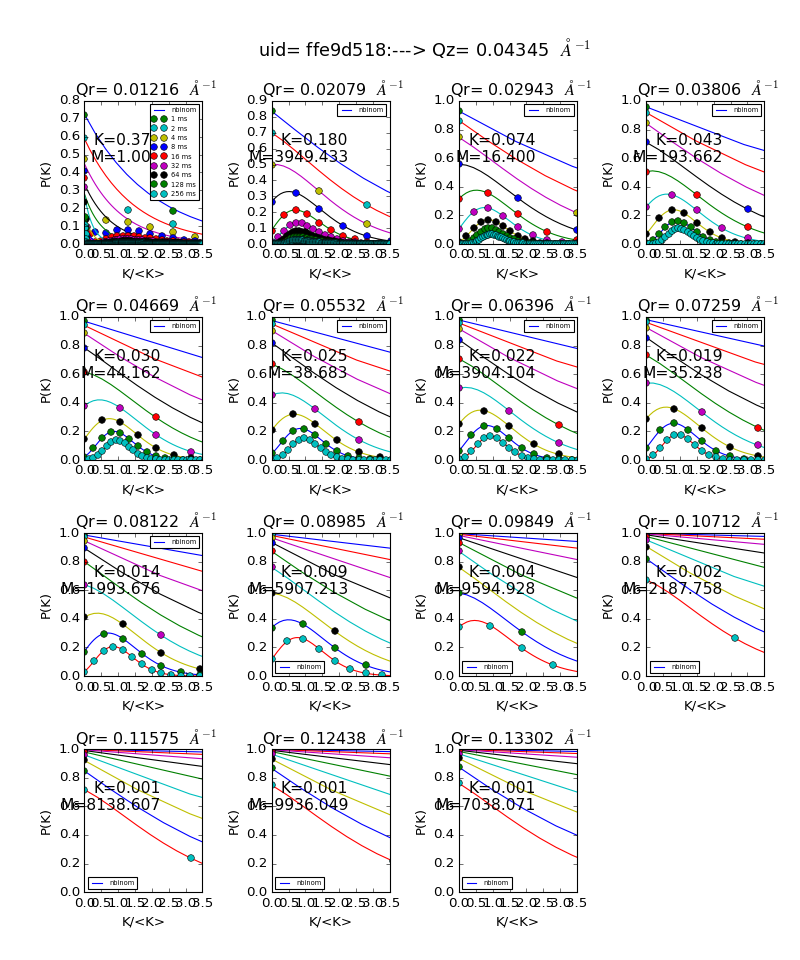

In [467]:
bn_M_val = {}
bn_K_val = {}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        bn_M_val[qz_ind* num_qr + sn]=[]
        bn_K_val[qz_ind* num_qr + sn]=[]        
        for j in range(len(time_steps)):     
            threshold=1e-4
            M= 100
            K= -1
            trys = 1
            for trys in range(7):         
                if M<=0 or  K <= 0:
                    threshold *= 10
                    trys +=1
                    
                    K_ = K_mean[qz_ind* num_qr + sn]  * 2**j    
                    n_mod.set_param_hint('M', value = 100, min=1.0, max= 10000 ) 
                    n_mod.set_param_hint('K', value = K_, 
                                 min=  K_/10, max=  K_*10) 

                    pars = n_mod.make_params()     
                    roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    
                    result_n = n_mod.fit(spe_cts_all[j, sn][roi],
                        bin_values=bin_edges[j, sn][:-1][roi], params =pars) 
                    M =  result_n.best_values['M']
                    K =  result_n.best_values['K']
             
                else:
                    break

            #print (M,K)
            bn_M_val[qz_ind* num_qr + sn].append(M)
            bn_K_val[qz_ind* num_qr + sn].append(K)
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            population_N  = 500*2**j  
            #population_N  = 10000
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
            fity = nbinom_dist( fitx, bn_K_val[qz_ind* num_qr + sn][j],
                               bn_M_val[qz_ind* num_qr + sn][j] ) # M and K are fitted best values
 
            if j == 0:
                art, = axes.plot( fitx_[:500],fity[:500], '-',  label="nbinom")
            else:
                art, = axes.plot( fitx_[:500],fity[:500], '-') 
            #if j == 0:
               # art, = axes.plot( fitx_,fity, '-',  label="nbinom")
            #else:
                #art, = axes.plot( fitx_,fity, '-')        
                
            if j==0:axes.annotate(r'K='+'%.3f\n'%( K) +r'M='+'%.3f'%(M),
                      xy=(.65, 0.55),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
                
                
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',)             
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  


In [468]:
K_mean

array([ 0.38237303,  0.17652289,  0.07161423,  0.04151951,  0.02951739,
        0.02423144,  0.02106524,  0.01891659,  0.01369414,  0.00836156,
        0.00419829,  0.00148836,  0.00123779,  0.00108712,  0.00100988,
        0.54096959,  0.18492724,  0.07727767,  0.04464761,  0.03106574,
        0.02452395,  0.02038103,  0.01715325,  0.0119164 ,  0.00718459,
        0.00355898,  0.00271693,  0.00226033,  0.00190928,  0.00168969])

In [469]:
K_mean_bn = []
for i in range(num_qz):
    for j in range(num_qr):
        K_mean_bn.append(    bn_K_val[i*num_qr+j][0]  )
K_mean_bn = np.array(K_mean_bn)        

In [470]:
K_mean_bn

array([ 0.37649687,  0.18294317,  0.07418293,  0.04289329,  0.03046884,
        0.02493529,  0.02163353,  0.01940351,  0.01403734,  0.00859343,
        0.00433231,  0.00155023,  0.00129475,  0.00113297,  0.00106373,
        0.37650529,  0.17996803,  0.07418293,  0.04289328,  0.03046884,
        0.02493529,  0.02163343,  0.01940351,  0.01403732,  0.00858802,
        0.00433231,  0.00155021,  0.00129475,  0.00113292,  0.00106372])

### Fit with Gamma Distribution

<IPython.core.display.Javascript object>


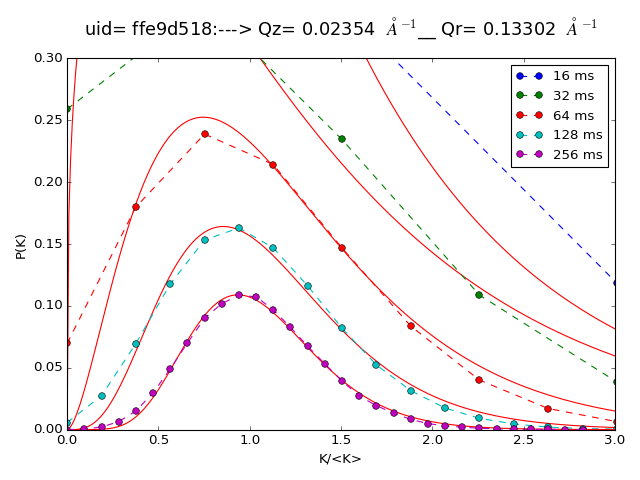

0.999994242579 0.693292176881
1.3408048511 1.75448226949
2.72958892545 3.12665605525
4.65821094976 5.78568144535
8.53651588779 11.2642597124


In [472]:
qz_ind =0
sn =  3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

#for j in range(len(time_steps)): 
for j in range(4,len(time_steps)):   
    threshold=1e-6
    M= -10    
    trys = 1
    for trys in range(7):
         
        if M<=0:
            threshold *= 10
            trys +=1  
            M_ = bn_M_val[sn][j]
            #g_mod.set_param_hint('M', value = M_, min= M_*.01, max= M_*100 ) 
            g_mod.set_param_hint('M', value = 2.0 ) 
            #g_mod.set_param_hint('K', value = K_mean[sn] * 2**j, 
                                 #min=K_mean[sn] * 2**j*.99, max= K_mean[sn] * 2**j*1.01 ) 
            K_ = K_mean[sn]*2**j
            #print (M_,K_)
            g_mod.set_param_hint('K', value = K_, min=K_*.01, max= K_*100 )
            
            pars = g_mod.make_params()     
            roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    
            result_g = g_mod.fit(spe_cts_all[j, sn][roi],
                    bin_values=bin_edges[j, sn][:-1][roi], params = pars)
                                 
                                 #parms = pars)
                            #K=K_mean[sn] * 2**j,
                                        # M =pars['M']) 
            M =  result_g.best_values['M'] 
            K =  result_g.best_values['K'] 
        else:
            break
            
           
    M_val=M
    K_val=K  #_mean[sn] * 2**j
    #print (M,K)
    #print (result_g.best_values['K'] )
    #print  (K_mean[sn] * 2**j)
            
    print (M_val,K_val)
    
    #  Using the best K and M values interpolate and get more values for fitting curve
    #if j<=3:population_N = 10000
    #else:population_N=len(Knorm_bin_edges[j, sn][:-1])
    population_N  = 5000*2**j   
    
    xlim=3.5
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )      
    
    #fitx_ = fitx_
    #fitx = np.linspace(0, xlim*K_mean[sn], population_N ) 
    fity = gamma_dist( fitx, K_val, M_val ) # M and K are fitted best values
    
    
    if j == 2:
        art, = axes.plot( fitx_[:5000],fity[:5000], '-k',  label="gamma")
    else:
        art, = axes.plot( fitx_[:5000],fity[:5000], '-r')                
                
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1][roi], spe_cts_all[j, sn][roi], '--o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, 3)    
    axes.set_ylim(0, 0.3) 
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K_val) +r'M='+'%.3f'%(M_val),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

In [365]:
%run speckle.py

<IPython.core.display.Javascript object>


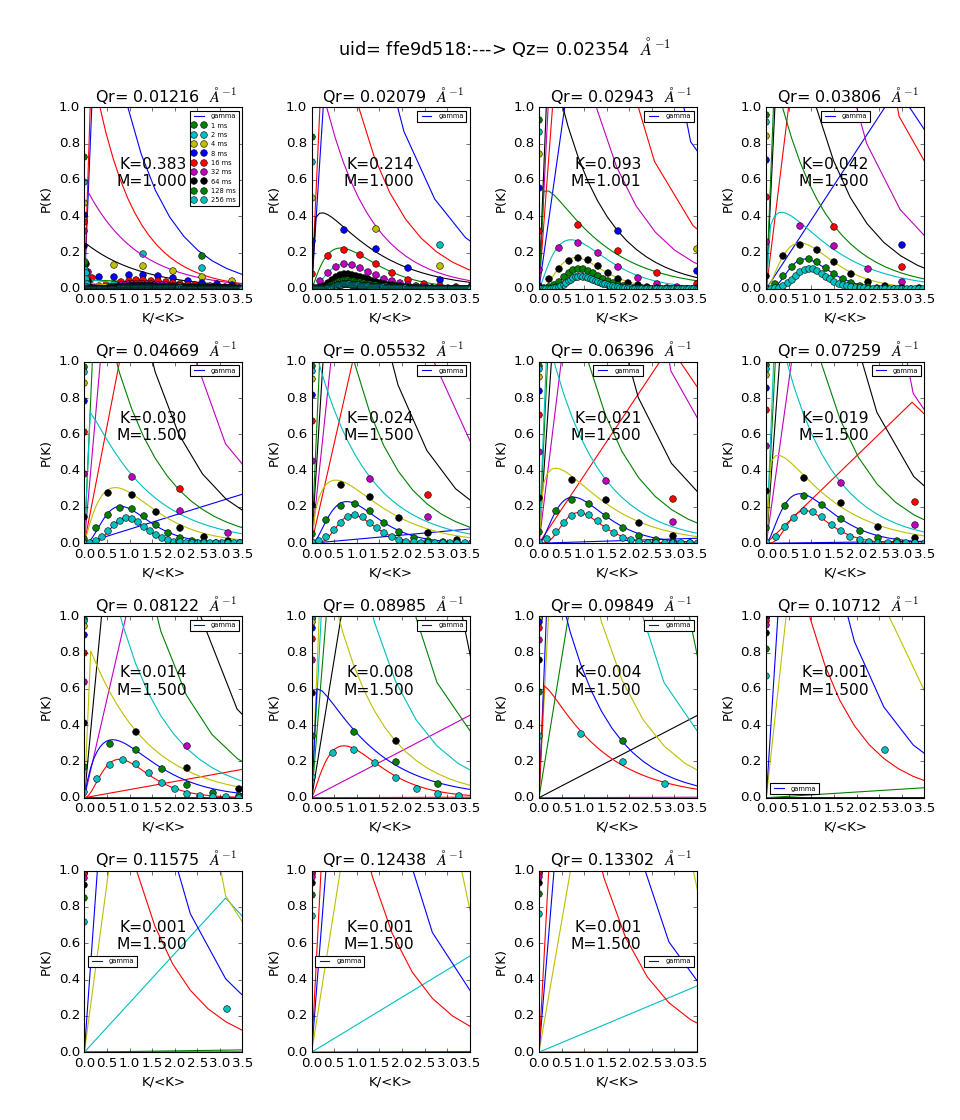

<IPython.core.display.Javascript object>


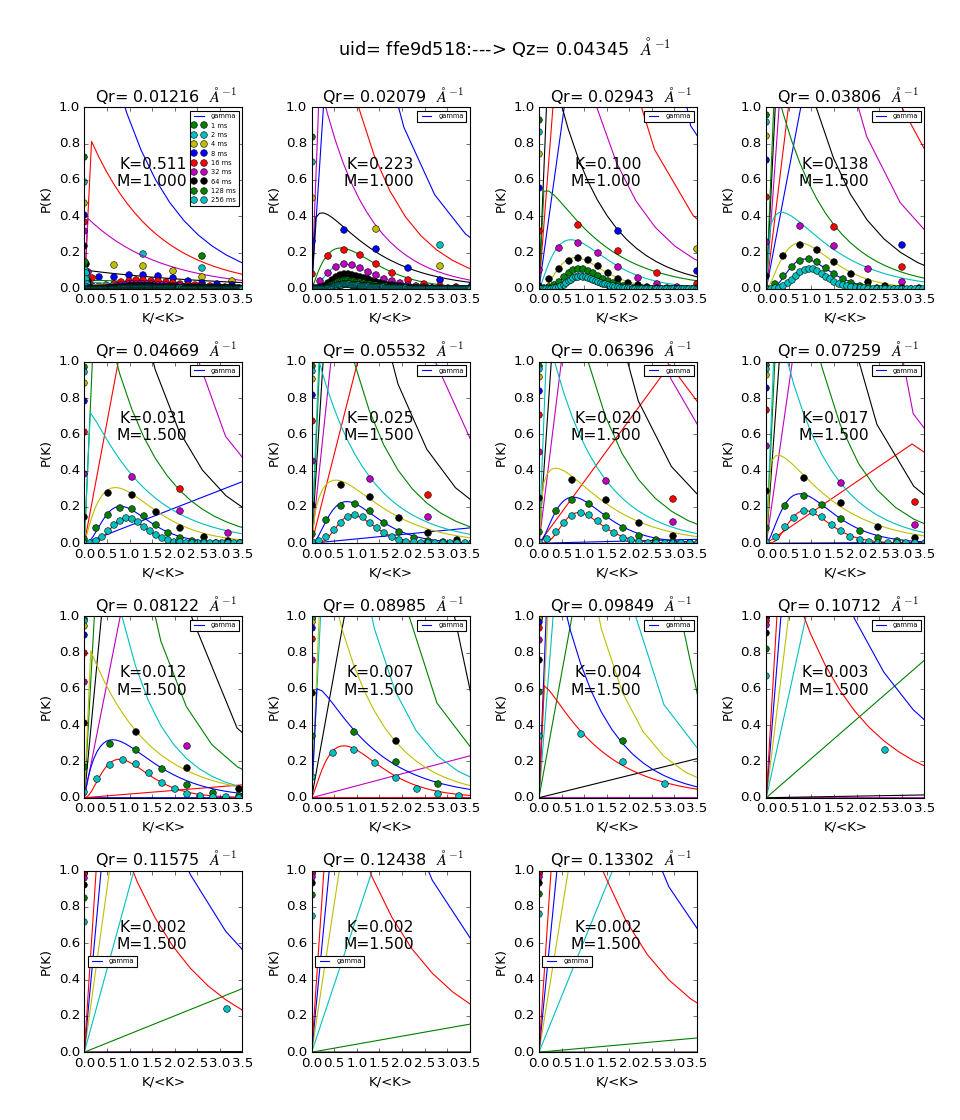

In [473]:
gm_M_val = {}
gm_K_val={}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(12,14))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        gm_M_val[qz_ind* num_qr + sn]=[]
        gm_K_val[qz_ind* num_qr + sn]=[]
        for j in range(len(time_steps)): 
        #for j in range(6,len(time_steps)):  
            threshold=1e-7
            M= -100            
            trys = 1
            for trys in range(7):         
                if M<=0:
                    threshold *= 10
                    trys +=1              
                    M_ = bn_M_val[sn][j]
                    K_ = K_mean[qz_ind* num_qr + sn] * 2**j
                    
                    g_mod.set_param_hint('M', value = 1.5)#, min= M_*.01, max= M_*100 )                     
                    #print (M_,K_)
                    g_mod.set_param_hint('K', value = K_, min=K_*.1, max= K_*10 )
 

                    pars = g_mod.make_params()     
                    roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    
                    result_g = g_mod.fit(spe_cts_all[j, sn][roi],
                        bin_values=bin_edges[j, sn][:-1][roi],
                                        params = pars) 
                    M =  result_g.best_values['M']
                    K =  result_g.best_values['K']
                    #print (result_n.best_values['K']) 
             
                else:
                    break

            #print (M,K)
            gm_M_val[qz_ind* num_qr + sn].append(M)
            gm_K_val[qz_ind* num_qr + sn].append(K) 
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            population_N  = 500*2**j  
            #population_N  = 10000
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
            fity = gamma_dist( fitx, gm_K_val[qz_ind* num_qr + sn][j], 
                              gm_M_val[qz_ind* num_qr + sn][j] ) # M and K are fitted best values
 
            if j == 0:
                art, = axes.plot( fitx_[:500],fity[:500], '-',  label="gamma")
            elif j>0:
                art, = axes.plot( fitx_[:500],fity[:500], '-') 
            else:
                pass
            #if j == 0:
               # art, = axes.plot( fitx_,fity, '-',  label="nbinom")
            #else:
                #art, = axes.plot( fitx_,fity, '-') 
        
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',) 
                
            if j==0:
                axes.annotate(r'K='+'%.3f\n'%( K) +r'M='+'%.3f'%(M),
                      xy=(.65, 0.55),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
            
        axes.set_xlim(0, 3.5)      
        axes.set_ylim(0, 1)    
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  
 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  

## Fit with Poisson Distribution

In [300]:
#bin_edges[7,0]

<IPython.core.display.Javascript object>


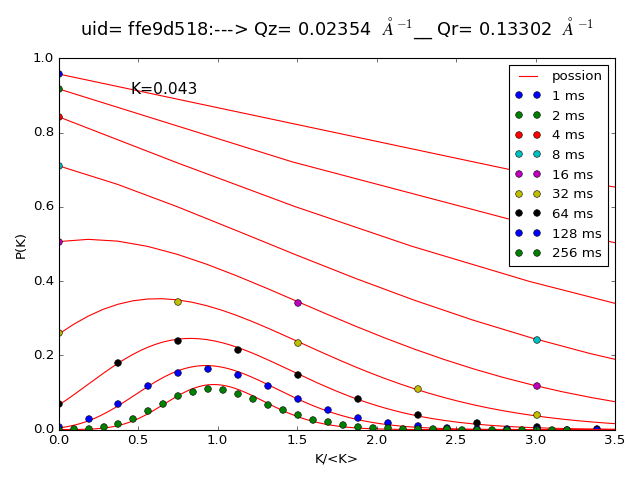

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/lmfit-0.8.3-py3.4.egg/lmfit/model.py:455: UserWarning: The keyword argument parms does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


In [474]:
qz_ind =0
sn =  3

fig = plt.figure(figsize=(8,6))
title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
#plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
axes = fig.add_subplot(111 ) 

for j in range(len(time_steps)): 
#for j in range(6,len(time_steps)):   
    threshold=1e-8
    K= -10    
    trys = 1
    for trys in range(7):
         
        if K<=0:
            threshold *= 10
            trys +=1  
                        
            roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
            K_ = K_mean[sn]*2**j
            p_mod.set_param_hint('K', value = K_, min=K_*.1, max= K_*10 )  
            pars = p_mod.make_params()    
            result_p = p_mod.fit(spe_cts_all[j, sn][roi],
                    bin_values=bin_edges[j, sn][:-1][roi],
                                 parms=pars)  
 
            K  =  result_p.best_values['K'] 
            #print (K,K_mean[sn]*2**j)
        else:
            break

    population_N  = 500*2**j   
    
    xlim=3.5
    fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
    fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
    
    #K=K_mean[sn]*2**j
    #print (K,K_mean[sn]*2**j)
    fity = poisson_dist( fitx, K  ) # M and K are fitted best values
    
    
    if j == 0:
        art, = axes.plot( fitx_[:500],fity[:500], '-r',  label="possion")
    else:
        art, = axes.plot( fitx_[:500],fity[:500], '-r')                
                
    #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     #label=str(time_steps[j])+" ms")
    art, = axes.plot(Knorm_bin_edges[j, sn][:-1][roi], spe_cts_all[j, sn][roi], 'o',
                     label=str(time_steps[j])+" ms")
            #else:
                #art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], '-o',)             
            
    axes.set_xlim(0, xlim)    
    #axes.set_ylim(0, 2) 
    axes.legend(loc='best', fontsize = 12)
   
    if j==0:axes.annotate(r'K='+'%.3f\n'%( K),
                      xy=(.25, 0.85),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
    axes.set_xlabel("K/<K>")
    axes.set_ylabel("P(K)")    

    title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
    axes.set_title( title,fontsize=16, y =1.05) 

fig.tight_layout() 

In [324]:
%run speckle.py

<IPython.core.display.Javascript object>


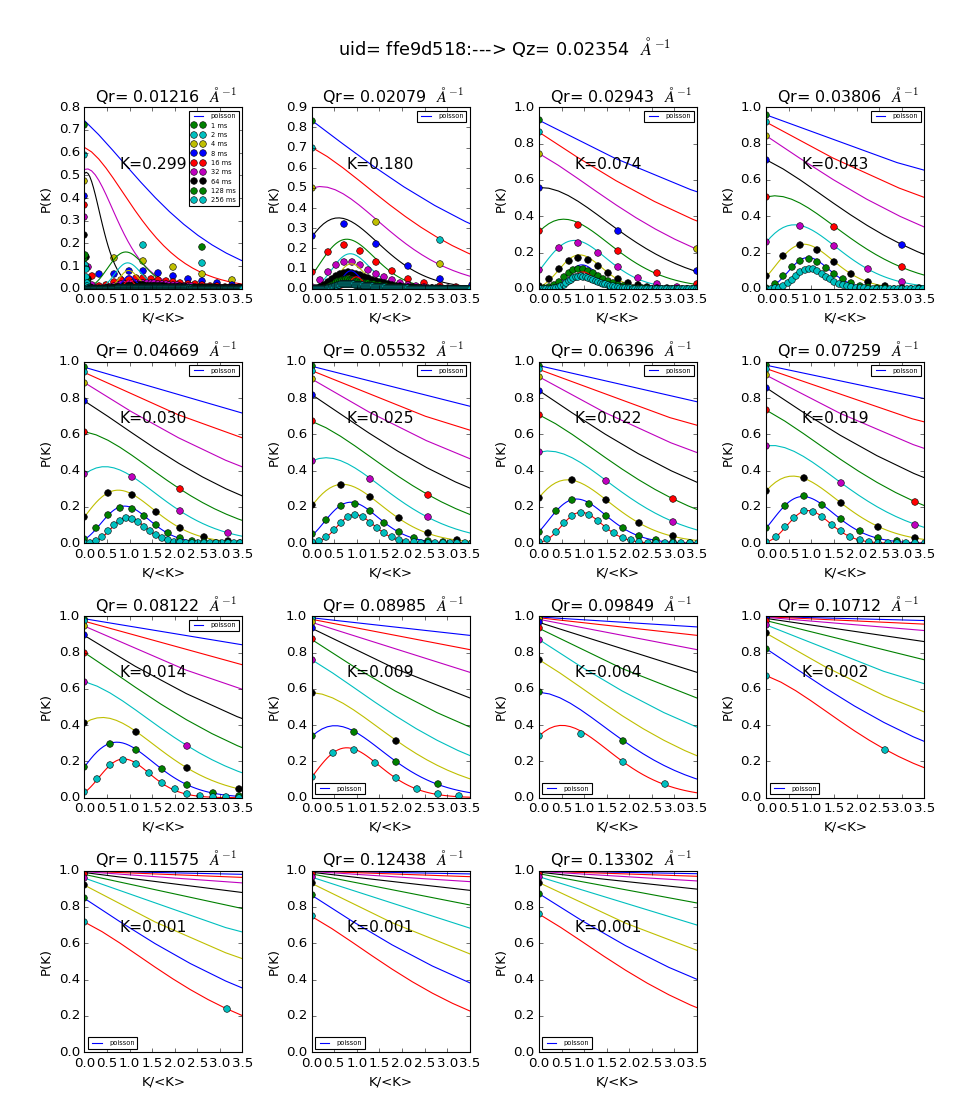

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/lmfit-0.8.3-py3.4.egg/lmfit/model.py:455: UserWarning: The keyword argument parms does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


<IPython.core.display.Javascript object>


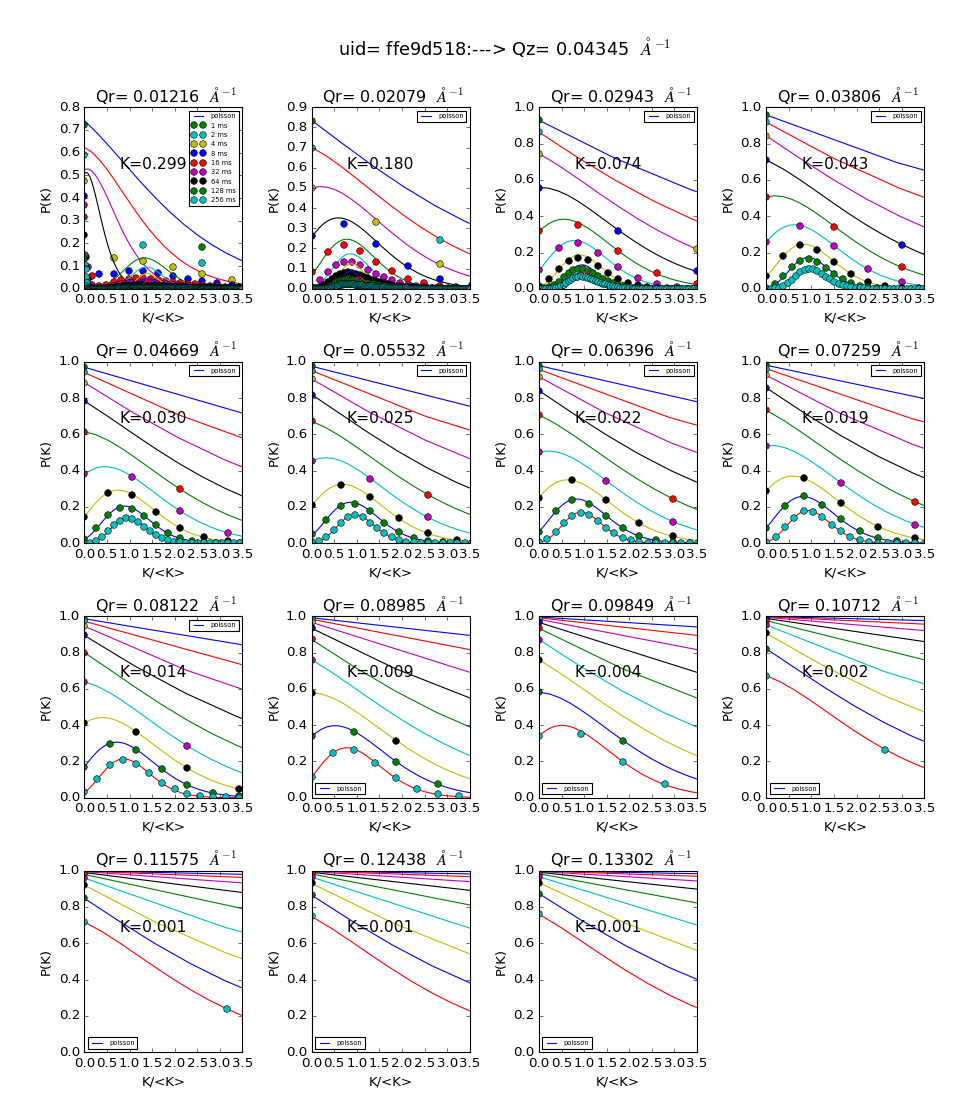

In [475]:
K_val = {}
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(12,14))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    
    for sn in range(num_qr):
        axes = fig.add_subplot(sx,sy,sn+1 ) 
        K_val[qz_ind* num_qr + sn]=[]
         
        for j in range(len(time_steps)): 
        #for j in range(6,len(time_steps)):  
            threshold=1e-7
            K= -100            
            trys = 1
            for trys in range(7):         
                if K<=0:
                    threshold *= 10
                    trys +=1 
                    roi = get_roi(data=spe_cts_all[j, sn], threshold=threshold)
                    #K_ = K_mean[sn]*2**j
                    K_ = K_mean[qz_ind* num_qr + sn]  * 2**j   
                    p_mod.set_param_hint('K', value = K_, min=K_*.1, max= K_*10 )  
                    pars = p_mod.make_params()    
                    result_p = p_mod.fit(spe_cts_all[j, sn][roi],
                        bin_values=bin_edges[j, sn][:-1][roi],
                                 parms=pars)  
                    K  =  result_p.best_values['K']
                else:
                    break

            #print (M,K)
            K_val[qz_ind* num_qr + sn].append(K)
             
         
            #  Using the best K and M values interpolate and get more values for fitting curve
            population_N  = 500*2**j  
            #population_N  = 10000
            fitx_ = np.linspace(0, max(Knorm_bin_edges[j, sn][:-1]), population_N     )   
            fitx = np.linspace(0, max(bin_edges[j, sn][:-1]), population_N )  
            fity = poisson_dist( fitx,  K_val[qz_ind* num_qr + sn][j] ) # M and K are fitted best values

            if j == 0:
                art, = axes.plot( fitx_,fity, '-',  label="poisson")
            else:
                art, = axes.plot( fitx_,fity, '-') 
        
            if sn == 0:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',
                     label=str(time_steps[j])+" ms")
            else:
                art, = axes.plot(Knorm_bin_edges[j, sn][:-1], spe_cts_all[j, sn], 'o',) 
                
            if j==0:axes.annotate(r'K='+'%.3f\n'%( K),
                      xy=(.65, 0.55),
                      xycoords='axes fraction', fontsize=14,
                      horizontalalignment='right', verticalalignment='bottom')
            
        axes.set_xlim(0, 3.5)         
        axes.legend(loc='best', fontsize = 6)
        
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")  

               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        axes.set_title( title  )

    fig.tight_layout()  

## Get the contast factor of detected signals is 1/M

$ \beta = 1/M $

In [476]:
contrast_factor = np.zeros((num_qzr, num_times))
for i in range(num_qz):
    for j in range(num_qr):
        contrast_factor[i*num_qr + j] =  1/np.array( bn_M_val[i*num_qr + j] )


In [477]:
contrast_factor[3  ]

array([ 0.00516956,  0.01385574,  0.01665922,  0.02033683,  0.02526933,
        0.02312549,  0.0228302 ,  0.02373482,  0.02380551])

In [478]:
times = np.array( time_steps ) * exposuretime

<IPython.core.display.Javascript object>


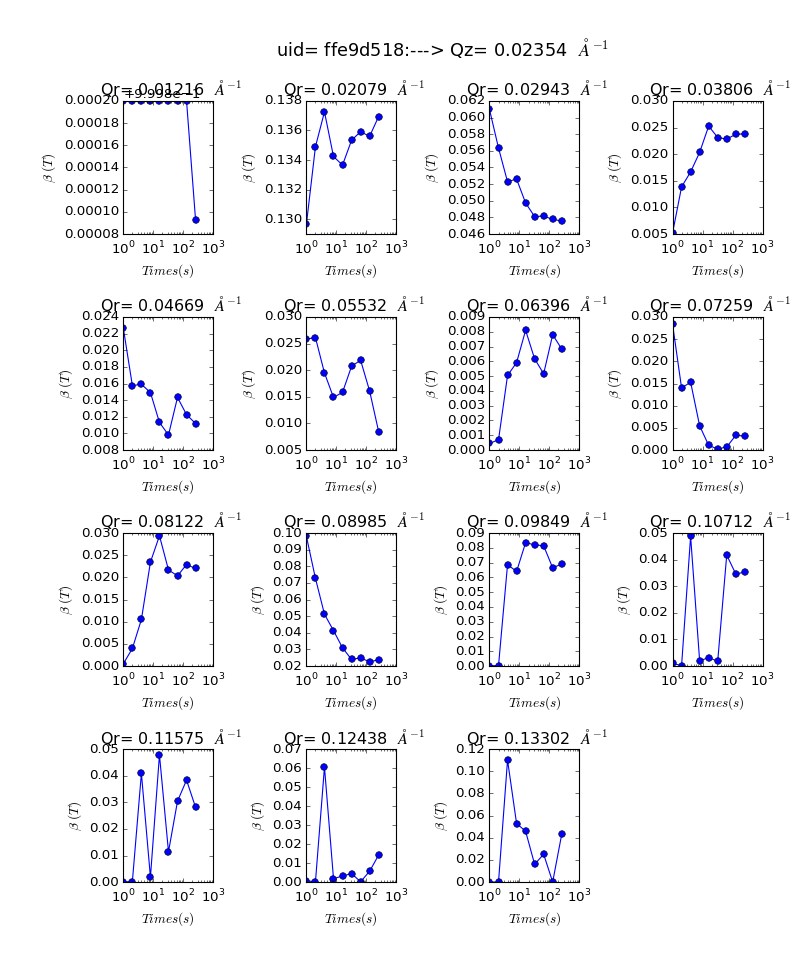

<IPython.core.display.Javascript object>


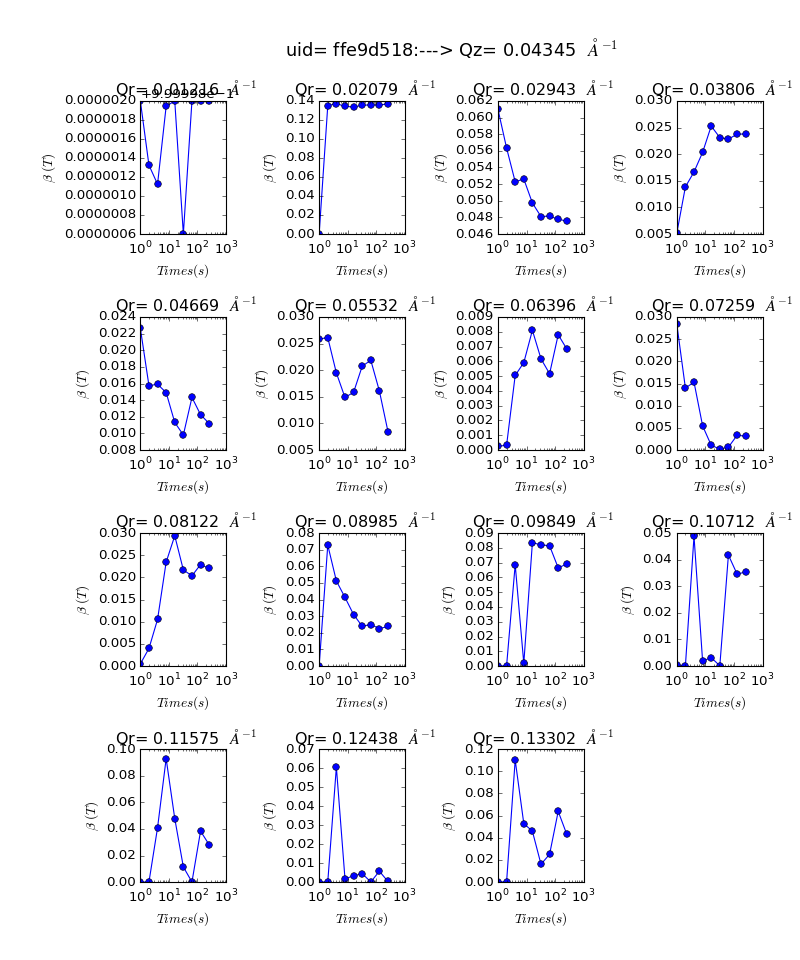

In [480]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
     
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    for sn in range(num_qr):
        ax = fig.add_subplot(sx, sy, sn+1 ) 
        y= contrast_factor[qz_ind*num_qr + sn, :]   
        #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(qr_center[sn])+ r'$\AA^{-1}$')         
        ax.set_xlabel(r"$Times (s)$")
        ax.set_ylabel(r"$\beta$ $(T)$")                
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )

    fig.tight_layout()          
        

        
        

### get fit of contrast factor

<IPython.core.display.Javascript object>


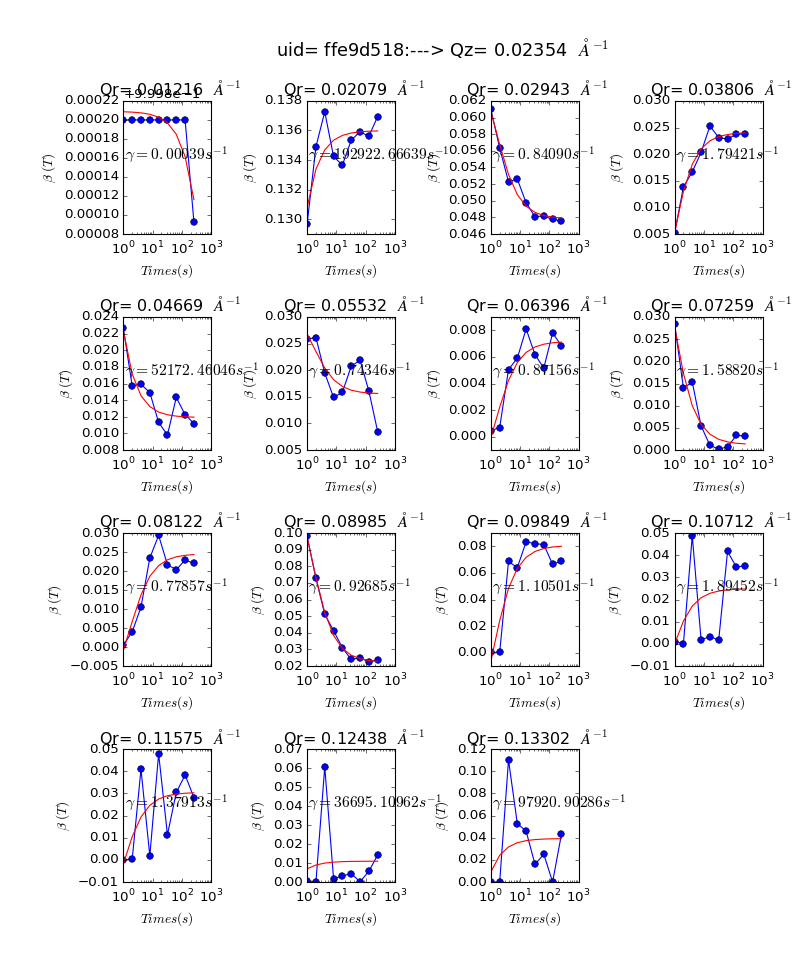

<IPython.core.display.Javascript object>


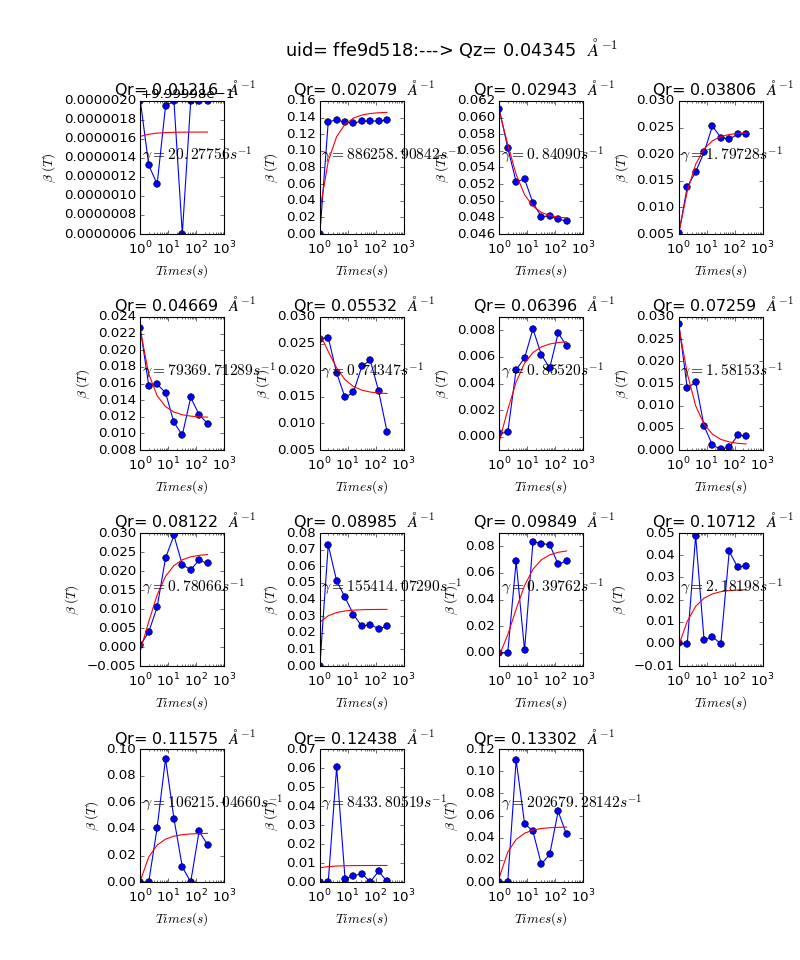

In [488]:
relax_rate = {}

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10,12))
    #fig = plt.figure()
    relax_rate[qz_ind] =[]
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    #M_val[qz_ind]={}
    #K_val[qz_ind]={}
    for sn in range(num_qr):
        ax = fig.add_subplot(sx, sy, sn+1 ) 
        y= contrast_factor[qz_ind*num_qr + sn, :]   
        #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(qr_center[sn])+ r'$\AA^{-1}$')     
        
        result_dc = dc_mod.fit(y, times=times,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
        best_rate = result_dc.best_values['relaxation_rate']
        relax_rate[qz_ind].append(best_rate)
        ax.semilogx(times, result_dc.best_fit, '-r')
    
        ax.set_xlabel(r"$Times (s)$")
        ax.set_ylabel(r"$\beta$ $(T)$")                
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
        
        txts = r'$\gamma$' + r'$ = %.5f$'%(best_rate) +  r'$ s^{-1}$'
        ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes) 
    

    fig.tight_layout()   

In [492]:
 #relax_rate[1]

<IPython.core.display.Javascript object>


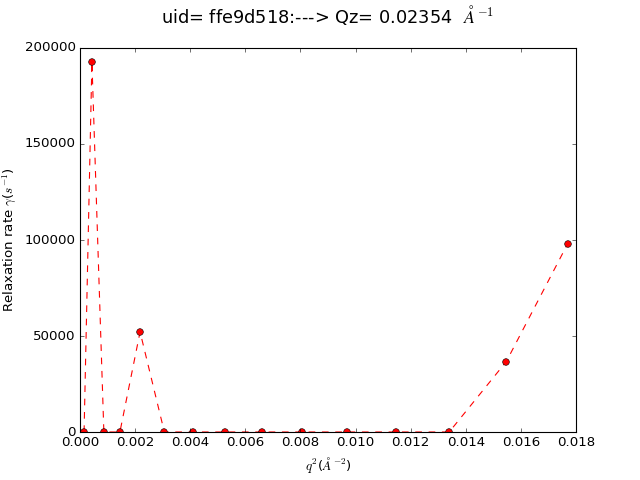

<IPython.core.display.Javascript object>


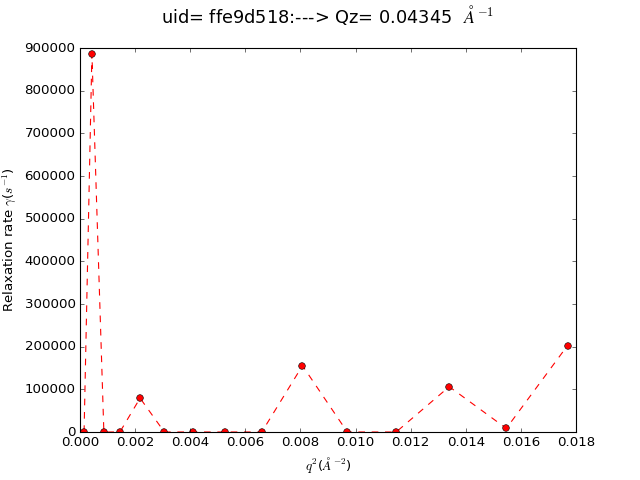

In [489]:
for qz_ind in range(num_qz):     
    #fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    fig, ax=plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    #if num_qz!=1:plt.axis('off')
        
    ax.plot(qr_center**2, relax_rate[qz_ind], 'ro', ls='--')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
    
    plt.show()

# Fitted the Diffusion Coefficinet D0

In [493]:
if True:
    D0={}
    gmfit={}
    for qz_ind in range(num_qz): 
        D0[qz_ind] = np.polyfit(qr_center**2, relax_rate[qz_ind], 1)
        gmfit[qz_ind] = np.poly1d( D0[qz_ind] )
        print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[qz_ind][0])

The fitted diffusion coefficient D0 is:  -6.81E+04   A^2S-1
The fitted diffusion coefficient D0 is:  -5.68E+06   A^2S-1


<IPython.core.display.Javascript object>


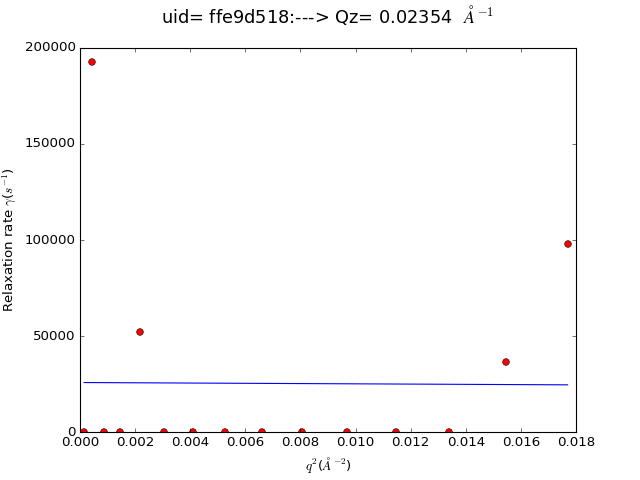

<IPython.core.display.Javascript object>


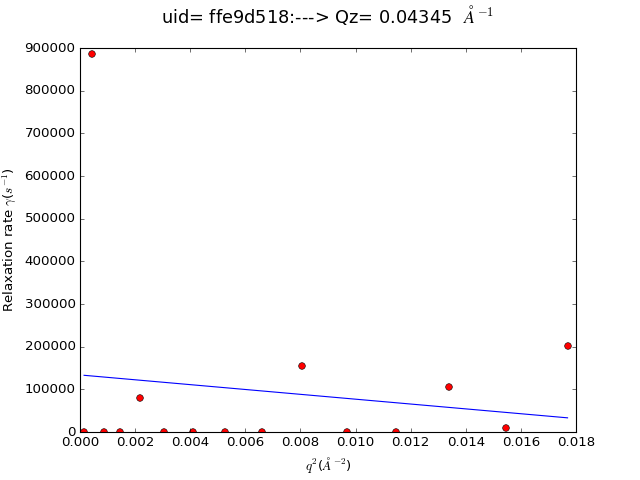

In [495]:
for qz_ind in range(num_qz): 
    fig,ax = plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05)
    ax.plot(qr_center**2, relax_rate[qz_ind], 'ro', ls='')
    ax.plot(qr_center**2,  gmfit[qz_ind](qr_center**2),  ls='-')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## A comparision with xpcs results

In [499]:
good_start =4000
good_end = 12001
tg2 = np.loadtxt(  path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end))
lags, g2 = tg2[:,0], tg2[:,1:]

In [502]:
plt.close('all')

<IPython.core.display.Javascript object>


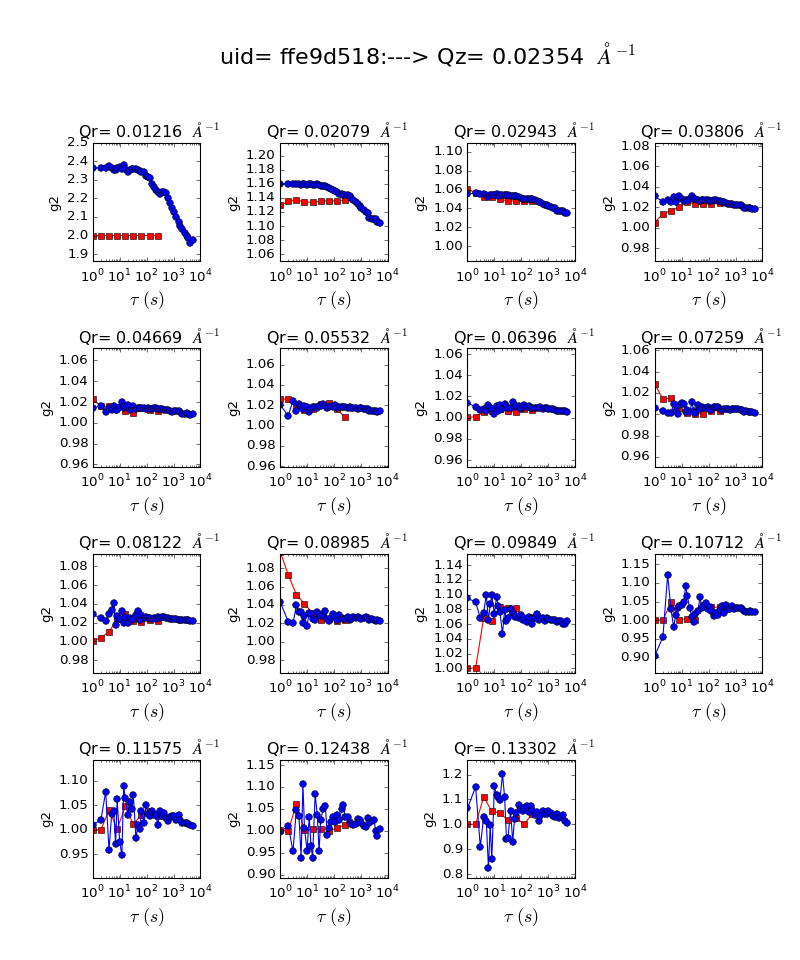

<IPython.core.display.Javascript object>


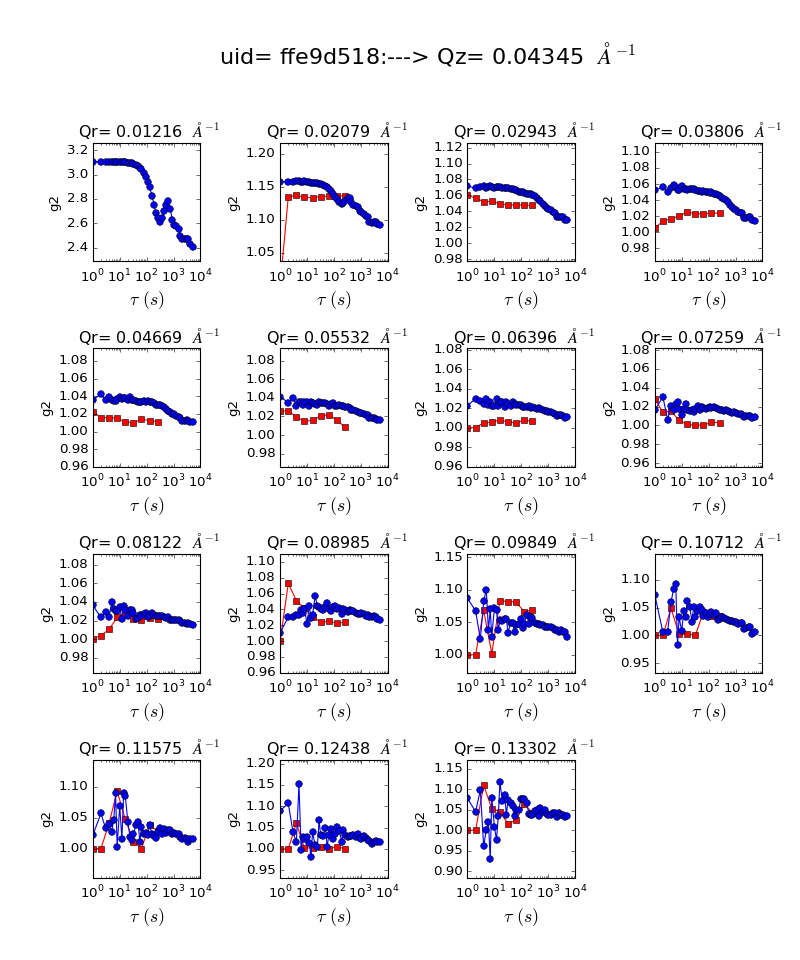

In [505]:
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
            
        yb= contrast_factor[qz_ind*num_qr + sn, :]   
        #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        ax.semilogx(times, yb+1, "-rs", 
                label="Q ="+ '%.4f  '%(qr_center[sn])+ r'$\AA^{-1}$')
    
        y=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y, '-bo', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  



In [500]:
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "__g2-&-beta for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-bo", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    
    y2=g2[:, sn]
    ax.semilogx(lags, y2 -1 , '-rs', markersize=6) 
    
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y2-1)*.95, max(y2[1:]-1) *1.05])
              
 
fig.tight_layout() 

NameError: name 'num_rings' is not defined